# SETUP

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd '/content/drive/MyDrive/OpenClassroom/P7_blanvillain_eric/'

In [ ]:
# importing Misc Libraries
import os
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import gc
import pickle
import warnings
import dill
warnings.filterwarnings('ignore')
from datetime import datetime
from time import time
import pprint

# importing Useful DataStructures
import pandas as pd
#import modin.pandas as pd
import numpy as np
from scipy.stats import uniform

# importing plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Plot settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set()

# for 100% jupyter notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

# ML
# Data preparation
from sklearn.model_selection import train_test_split  #cross_validate
from sklearn.model_selection import StratifiedKFold
# Metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score

# Skopt functions, baesian optimisation
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, VerboseCallback
from skopt.space import Real, Categorical, Integer

# Classifiers
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Module perso
# from helpers import *
# from P7_FONCTIONS import *

# pandas DataFrame column and row display limits
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'figure.figsize': [12, 8]})
plt.style.use('seaborn-whitegrid')

# <span class="bg-danger">SOURCES<span> 
__Métriques classification__ https://towardsdatascience.com/the-ultimate-guide-to-binary-classification-metrics-c25c3627dd0a
    
__Optimisation Pycaret__ https://zephyrnet.com/fr/optimisation-des-hyperparam%C3%A8tres-bay%C3%A9siens-avec-tune-sklearn-dans-pycaret/amp/
    
__Optimisation bayesienne__ https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f

In [ ]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

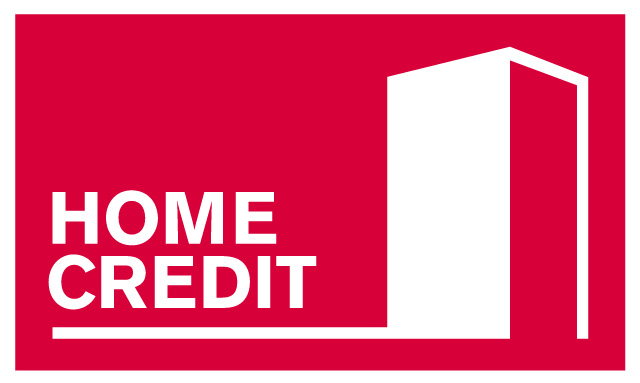

In [ ]:
from pyquickhelper.helpgen import NbImage
NbImage("Home_credit_logo_640px.jpg")

# <span class="bg-danger">MODELISATION<span> 

## <span class="bg-info"> 1. Chargement du jeu de données<span> 

- __train__ est le jeu de données obtenu après preprocessing (cleaning, feature engineering et feature selection) et assemblage d'application_train avec 6 autres jeux de données
- __test__ est le jeu de données obtenu après preprocessing (cleaning, feature engineering et feature selection) et assemblage d'application_test avec 6 autres jeux de données
- __train et test__ sont composés des mêmes variables, à l'exception de __'TARGET'__ absente de test, qui est le jeu __non étiqueté.__

In [ ]:
train = pd.read_csv('train_model_109.csv', encoding='latin1')
test = pd.read_csv('test_model_108.csv')

In [ ]:
train.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_INCOME_TOTAL,ANNUITY_INCOME,APARTMENTS_AVG,BASEMENTAREA_AVG,CB_AMT_BALANCE_mean,CB_CNT_DRAWINGS_ATM_CURRENT_mean,CB_CNT_DRAWINGS_CURRENT_mean,CODE_GENDER,CREDIT_ANNUITY_RATIO,CREDIT_INCOME,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,ENTRANCES_AVG,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_MAX,EXT_SOURCE_SUM,EXT_SOURCE_VAR,FLAGS_DOCUMENTS_AVG,FLAG_CONTACTS_SUM,FLAG_OWN_CAR,FLAG_WORK_PHONE,FLOORSMAX_AVG,HOUR_APPR_PROCESS_START,INCOME_BY_ORG,Instal_AMT_INSTALMENT_max,Instal_AMT_INSTALMENT_mean,Instal_AMT_INSTALMENT_sum,Instal_AMT_PAYMENT_DIFF_max,Instal_AMT_PAYMENT_DIFF_mean,Instal_AMT_PAYMENT_DIFF_sum,Instal_AMT_PAYMENT_min,Instal_DAYS_BEFORE_DUE_max,Instal_DAYS_BEFORE_DUE_mean,Instal_DAYS_BEFORE_DUE_sum,Instal_DAYS_ENTRY_PAYMENT_mean,Instal_DAYS_ENTRY_PAYMENT_sum,Instal_DAYS_PAST_DUE_max,Instal_DAYS_PAST_DUE_mean,Instal_DAYS_PAST_DUE_sum,Instal_NUM_INSTALMENT_VERSION_mean,Instal_NUM_INSTALMENT_VERSION_nunique,Instal_PAYMENT_RATIO_mean,LANDAREA_AVG,NAME_FAMILY_STATUS_Married,NAME_INCOME_TYPE_Working,NEW_PHONE_TO_EMPLOY_RATIO,NONLIVINGAREA_AVG,OCCUPATION_TYPE_Drivers,OVER_EXPECT_CREDIT,POS_CASH_MONTHS_BALANCE_max,POS_CASH_MONTHS_BALANCE_size,POS_CASH_SK_DPD_DEF_max,POS_CASH_SK_DPD_max,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REG_CITY_NOT_LIVE_CITY,TARGET_NEIGHBORS_500_MEAN,YEARS_BEGINEXPLUATATION_AVG,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_mean,bureau_CREDIT_ENDDATE_BINARY_mean,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_var,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_var,previous_AMT_ANNUITY_max,previous_AMT_ANNUITY_min,previous_AMT_APPLICATION_mean,previous_AMT_APPLICATION_min,previous_AMT_DOWN_PAYMENT_max,previous_AMT_GOODS_PRICE_min,previous_APP_CREDIT_PERC_mean,previous_APP_CREDIT_PERC_min,previous_CNT_PAYMENT_mean,previous_CNT_PAYMENT_sum,previous_DAYS_DECISION_mean,previous_DAYS_DECISION_min,previous_DAYS_FIRST_DUE_sum,previous_DAYS_LAST_DUE_max,previous_LOAN_RATE_max,previous_LOAN_RATE_mean,previous_NAME_CLIENT_TYPE_New_count_norm,previous_NAME_CLIENT_TYPE_Refreshed_count_norm,previous_NAME_CONTRACT_STATUS_mean,previous_NAME_TYPE_SUITE_Family_count_norm,previous_NAME_TYPE_SUITE_XNA_count,previous_NAME_TYPE_SUITE_XNA_count_norm,previous_RATE_DOWN_PAYMENT_max,previous_SELLERPLACE_AREA_sum,TARGET
0,24700.5,406597.5,202500.0,0.121978,0.0247,0.0369,26793.606316,0.270833,0.216216,0,16.461104,2.007889,-9461,-637.0,-2120,-1134.0,-3648.0,2.0,0.0690,0.083037,0.262949,0.139376,0.262949,0.485361,0.005646,0.05,4,0,0,0.0833,10,157500.0,53093.745,11559.247105,219625.695,0.000,0.000000,0.000,9251.775,31.0,20.421053,388.0,-315.421053,-5993.0,0.0,0.000000,0.0,1.052632,2.0,1.000000,0.0369,0,1,1.780220,0.0000,0,1,-1.0,19.0,0.0,0.0,0.018801,2,0,0.256,0.9722,1681.029,49156.200,31988.565,0.0,108131.945625,0.625000,0.0,0.0,0.0,780.0,-349.000000,-1072.0,-499.875000,-103.0,-1437.0,186150.000000,-36.0,266248.300000,9251.775,9251.775,179055.00,179055.0,0.0,179055.00,1.000000,1.000000,24.000000,24.0,-606.000000,-606.0,-565.0,-25.0,0.051670,0.051670,1.000000,0.000000,0.0,0.000000,1.0,1.000000,0.000000,500.0,1
1,35698.5,1293502.5,270000.0,0.132217,0.0959,0.0529,26793.606316,0.270833,0.216216,1,36.234085,4.790750,-16765,-1188.0,-291,-828.0,-1186.0,0.0,0.0345,0.311267,0.622246,0.535276,0.622246,1.468789,0.017161,0.05,4,0,0,0.2917,11,135000.0,560835.360,64754.586000,1618864.650,0.000,0.000000,0.000,6662.970,14.0,7.160000,179.0,-1385.320000,-34633.0,0.0,0.000000,0.0,1.040000,2.0,1.000000,0.0130,1,0,0.696970,0.0098,0,1,-18.0,28.0,0.0,0.0,0.003541,1,0,0.040,0.9851,0.000,0.000,

In [ ]:
train.shape, test.shape

((307511, 109), (48744, 108))

In [ ]:
#Get all feature names from the dataset
features = [f for f in train.columns if f not in ['TARGET']]
train[features] = train[features].fillna(train[features].mean()).clip(-1e9,1e9)

features_test = [f for f in test.columns]
test[features_test] = test[features_test].fillna(test[features_test].mean()).clip(-1e9,1e9)

In [ ]:
summarise(train), summarise(test)

(                                                n_missing  p_missing  \
 AMT_ANNUITY                                             0        0.0   
 bureau_AMT_CREDIT_SUM_OVERDUE_mean                      0        0.0   
 bureau_DAYS_CREDIT_min                                  0        0.0   
 bureau_DAYS_CREDIT_max                                  0        0.0   
 bureau_DAYS_CREDIT_UPDATE_mean                          0        0.0   
 bureau_DAYS_CREDIT_ENDDATE_min                          0        0.0   
 bureau_DAYS_CREDIT_ENDDATE_mean                         0        0.0   
 bureau_DAYS_CREDIT_ENDDATE_max                          0        0.0   
 bureau_CREDIT_TYPE_Mortgage_count_norm                  0        0.0   
 bureau_CREDIT_TYPE_Microloan_count_norm                 0        0.0   
 bureau_CREDIT_TYPE_Microloan_count                      0        0.0   
 bureau_CREDIT_ENDDATE_BINARY_mean                       0        0.0   
 bureau_AMT_CREDIT_SUM_mean                        

## <span class="bg-info"> 2. Première approche avec PYCARET<span> 

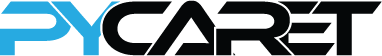

In [ ]:
NbImage("logo.png")

In [ ]:
import pycaret
pycaret.__version__

'2.3.0'

https://pycaret.readthedocs.io/en/latest/api/classification.html

__PyCaret__ est une bibliothèque d'apprentissage automatique open source à __low code__ en Python qui vise à réduire le temps nécessaire pour expérimenter différents modèles d'apprentissage automatique.

__Index__
- __Obtenir des données (get_data())__ : Comment importer des données depuis le dépôt PyCaret.
- __Configuration de l'environnement (setup())__ : Comment configurer une expérience dans PyCaret.
- __Créer un modèle (create_model())__ : Comment créer un modèle, effectuer une validation croisée stratifiée et évaluer les métriques de classification.
- __Ajuster le modèle (tune_model())__ : Comment ajuster automatiquement les hyper-paramètres d'un modèle.
- __Tracer le modèle (plot_model())__ : Comment analyser les performances du modèle à l'aide de divers graphiques.
- __Prédire le modèle (predict_model())__ : Comment faire des prédictions sur des données nouvelles/non vues.
- __Sauvegarder (save_model()) / Charger le modèle (load_model())__ : Comment sauvegarder / charger un modèle pour une utilisation ultérieure.

In [ ]:
from pycaret.classification import *

### <span class="bg-warning"> 2.1 Set up du jeu de données<span>  

In [ ]:
# Setup du jeu de données
grid = setup(data=train,
             target='TARGET',
             fix_imbalance=True,#SMOTE par défaut
             data_split_stratify=True,
             html=False,
             silent=True,
             verbose=True)

Setup Succesfully Completed!


,Description,Value
0,session_id,6711
1,Target,TARGET
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(307511, 109)"
5,Missing Values,False
6,Numeric Features,98
7,Categorical Features,10
8,Ordinal Features,False
9,High Cardinality Features,False


__Récupérer les données transformées par Pycaret__

- X: Transformed dataset (X)

- y: Transformed dataset (y)

- X_train: Transformed train dataset (X)

- X_test: Transformed test/holdout dataset (X)

- y_train: Transformed train dataset (y)

- y_test: Transformed test/holdout dataset (y)

In [ ]:
# Récupération de X_train, y_train créés par Pycaret

X_pycaret = get_config('X')
y_pycaret = get_config('y')

X_train_pycaret = get_config('X_train')
y_train_pycaret = get_config('y_train')

X_test_pycaret = get_config('X_test')
y_test_pycaret = get_config('y_test')

In [ ]:
X_pycaret.shape, y_pycaret.shape, X_train_pycaret.shape, y_train_pycaret.shape, X_test_pycaret.shape, y_test_pycaret.shape

((307511, 115), (307511,), (215257, 115), (215257,), (92254, 115), (92254,))

### <span class="bg-warning"> 2.2 Modèles disponibles<span>  

In [ ]:
# Modèles
models(raise_errors=True)

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


### <span class="bg-warning"> 2.3 Comparer les modèles<span>  

In [ ]:
# Comparaison de différent modèles 
best_models = compare_models(
    include=['lr', 'lightgbm', 'ada', 'rf', 'catboost'],
    n_select=2,
    sort='AUC',
    verbose=True  # Imprimer les résultats au fur et à mesure
)
# Stockage de la grille de score dans un tableau
best_models_scores_df = pull()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.613,0.6632,0.6273,0.1243,0.2074,0.084,0.1325,41.786


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9194,0.7808,0.0267,0.5078,0.0507,0.043,0.1023,9.635
lr,Logistic Regression,0.6130,0.6632,0.6273,0.1243,0.2074,0.084,0.1325,41.786


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9194,0.7808,0.0267,0.5078,0.0507,0.0430,0.1023,9.635
ada,Ada Boost Classifier,0.9125,0.7406,0.0617,0.2964,0.1018,0.0763,0.1032,45.305
lr,Logistic Regression,0.6130,0.6632,0.6273,0.1243,0.2074,0.0840,0.1325,41.786


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9194,0.7808,0.0267,0.5078,0.0507,0.0430,0.1023,9.635
rf,Random Forest Classifier,0.9188,0.7527,0.0102,0.3975,0.0200,0.0159,0.0529,54.897
ada,Ada Boost Classifier,0.9125,0.7406,0.0617,0.2964,0.1018,0.0763,0.1032,45.305
lr,Logistic Regression,0.6130,0.6632,0.6273,0.1243,0.2074,0.0840,0.1325,41.786


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9190,0.7828,0.0558,0.4850,0.1000,0.0848,0.1435,76.660
lightgbm,Light Gradient Boosting Machine,0.9194,0.7808,0.0267,0.5078,0.0507,0.0430,0.1023,9.635
rf,Random Forest Classifier,0.9188,0.7527,0.0102,0.3975,0.0200,0.0159,0.0529,54.897
ada,Ada Boost Classifier,0.9125,0.7406,0.0617,0.2964,0.1018,0.0763,0.1032,45.305
lr,Logistic Regression,0.6130,0.6632,0.6273,0.1243,0.2074,0.0840,0.1325,41.786


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9190,0.7828,0.0558,0.4850,0.1000,0.0848,0.1435,76.660
lightgbm,Light Gradient Boosting Machine,0.9194,0.7808,0.0267,0.5078,0.0507,0.0430,0.1023,9.635
rf,Random Forest Classifier,0.9188,0.7527,0.0102,0.3975,0.0200,0.0159,0.0529,54.897
ada,Ada Boost Classifier,0.9125,0.7406,0.0617,0.2964,0.1018,0.0763,0.1032,45.305
lr,Logistic Regression,0.6130,0.6632,0.6273,0.1243,0.2074,0.0840,0.1325,41.786


In [ ]:
print(best_models)

[<catboost.core.CatBoostClassifier object at 0x00000219D1968100>, LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=6711, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)]


### <span class="bg-warning"> 2.4 Conclusions : modèles retenus<span>  

##### Modèles retenus :
    
- __catboost__
- __lightgbm__

### <span class="bg-warning"> 2.5 Optimisation des 2 meilleurs modèles<span>  

#### <span class="bg-success"> 2.5.1 Catboost<span>

##### Modèle

In [ ]:
catboost = create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9204,0.7899,0.0719,0.5531,0.1273,0.1108,0.1786
1,0.9181,0.7723,0.0489,0.4337,0.0879,0.0727,0.1242
2,0.9196,0.7863,0.0552,0.5217,0.0999,0.0858,0.1503
3,0.9194,0.7860,0.0547,0.5108,0.0988,0.0845,0.1474
4,0.9183,0.7843,0.0558,0.4533,0.0994,0.0832,0.1370
5,0.9183,0.7757,0.0575,0.4545,0.1021,0.0856,0.1394
6,0.9188,0.7794,0.0547,0.4774,0.0981,0.0829,0.1406
7,0.9184,0.7777,0.0455,0.4463,0.0825,0.0686,0.1222
8,0.9194,0.7925,0.0616,0.5071,0.1099,0.0940,0.1558
9,0.9192,0.7842,0.0518,0.4918,0.0938,0.0796,0.1398


##### Optimisation

In [ ]:
catboost_tuned = tune_model(catboost, optimize='AUC', choose_better=True)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 61.5min finished


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9201,0.7884,0.0455,0.5683,0.0842,0.0731,0.1443
1,0.9187,0.7683,0.0293,0.4435,0.0550,0.0455,0.0976
2,0.9203,0.7877,0.0374,0.6075,0.0705,0.0617,0.1367
3,0.9201,0.7865,0.0397,0.5702,0.0742,0.0644,0.1351
4,0.9190,0.7817,0.0316,0.4741,0.0593,0.0497,0.1063
5,0.9185,0.7802,0.0362,0.4406,0.0670,0.0554,0.1080
6,0.9198,0.7801,0.0374,0.5508,0.0700,0.0604,0.1281
7,0.9193,0.7810,0.0299,0.4952,0.0565,0.0477,0.1066
8,0.9202,0.7879,0.0391,0.5862,0.0734,0.0639,0.1366
9,0.9198,0.7817,0.0357,0.5439,0.0670,0.0576,0.1241


##### Visualisation

In [ ]:
plot_model(catboost_tuned, plot="parameter")

,Parameters
nan_mode,Min
eval_metric,Logloss
iterations,1000
sampling_frequency,PerTree
leaf_estimation_method,Newton
grow_policy,SymmetricTree
penalties_coefficient,1
boosting_type,Plain
model_shrink_mode,Constant
feature_border_type,GreedyLogSum


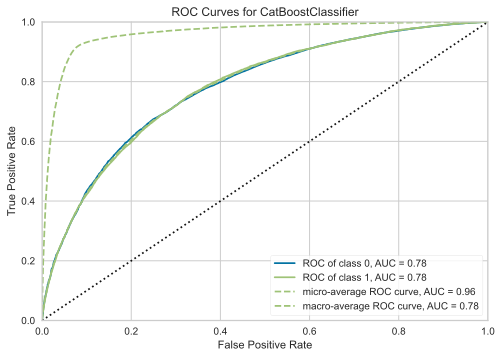

In [ ]:
plot_model(estimator = catboost_tuned, plot = 'auc')

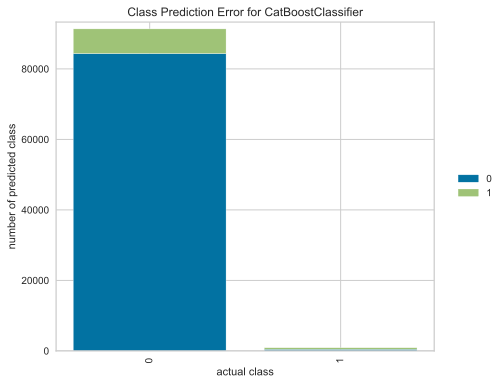

In [ ]:
plot_model(estimator = catboost_tuned, plot = 'error')

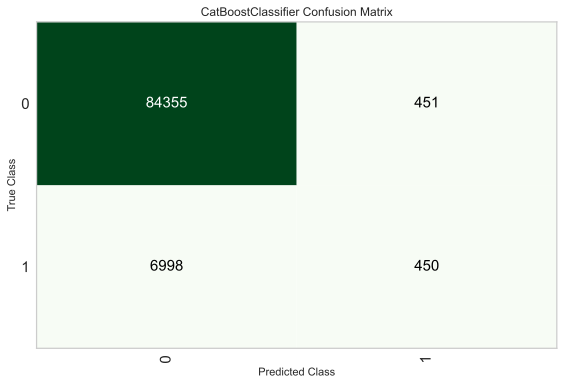

In [ ]:
plot_model(estimator = catboost_tuned, plot = 'confusion_matrix')

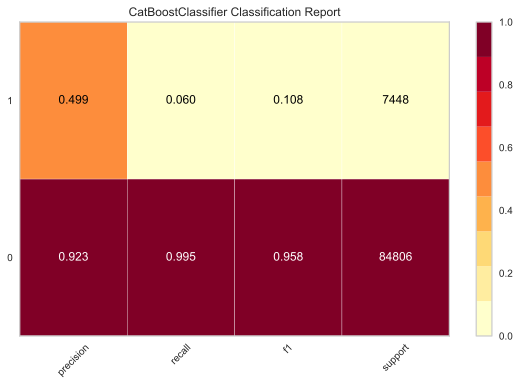

In [ ]:
plot_model(estimator = catboost_tuned, plot = 'class_report')

##### Résultat

In [ ]:
plot_model(catboost_tuned, plot="parameter")

,Parameters
nan_mode,Min
eval_metric,Logloss
iterations,1000
sampling_frequency,PerTree
leaf_estimation_method,Newton
grow_policy,SymmetricTree
penalties_coefficient,1
boosting_type,Plain
model_shrink_mode,Constant
feature_border_type,GreedyLogSum


##### Sauvegarde du modèle catboost optimisé

In [ ]:
#Utilisation de JobLib pour sérialiser et enregistrer le modèle catboost optimisés
from joblib import dump, load
# save model catboost tuned  to disk
dump(catboost_tuned , 'catboost_tuned_hyperopt.joblib', compress=1)

['catboost_tuned_hyperopt.joblib']

#### <span class="bg-success"> 2.5.2 Lightgbm<span>

##### Modèle

In [ ]:
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9203,0.7882,0.0374,0.6019,0.0704,0.0616,0.1358
1,0.9187,0.7662,0.0242,0.4375,0.0458,0.0377,0.0876
2,0.9191,0.7847,0.0201,0.4730,0.0386,0.0322,0.0846
3,0.9196,0.7826,0.0253,0.5432,0.0484,0.0415,0.1043
4,0.9190,0.7795,0.0236,0.4659,0.0449,0.0374,0.0906
5,0.9190,0.7791,0.0247,0.4725,0.0470,0.0393,0.0937
6,0.9194,0.7800,0.0305,0.5196,0.0576,0.0491,0.1112
7,0.9192,0.7789,0.0242,0.4884,0.0461,0.0388,0.0948
8,0.9196,0.7869,0.0305,0.5354,0.0577,0.0495,0.1135
9,0.9196,0.7822,0.0265,0.5412,0.0505,0.0433,0.1065


##### Optimisation bayesienne

- 1. Construire un __modèle de probabilité de substitution de la fonction objectif__.
- 2. __Trouver les hyperparamètres__ les plus performants sur le modèle de substitution.
- 3. __Appliquer ces hyperparamètres à la fonction objectif réelle__
- 4. __Mettre à jour__ le modèle de substitution en __incorporant les nouveaux résultats__.
- 5. Répéter les étapes 2-4 jusqu'à ce que le nombre maximal d'itérations ou de temps soit atteint.

Le but du raisonnement bayésien est de devenir «moins faux» avec plus de données, ce que font ces approches en mettant continuellement à jour le modèle de probabilité de substitution après chaque évaluation de la fonction objective.

In [ ]:
lgbm_tuned = tune_model(lgbm, optimize='AUC', choose_better=True, search_library = "tune-sklearn", search_algorithm="hyperopt", n_iter=20)

(pid=12600) Windows fatal exception: access violation
(pid=12600) 
(pid=None) C:\Users\Troussard Family\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
(pid=None) C:\Users\Troussard Family\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
(pid=None) C:\Users\Troussard Family\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
(pid=None)   warnings.warn("loaded more than 1 DLL from .libs:"


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9203,0.7906,0.0541,0.5663,0.0987,0.0859,0.1571
1,0.9187,0.7700,0.0437,0.4634,0.0799,0.0669,0.1231
2,0.9197,0.7853,0.0466,0.5329,0.0857,0.0737,0.1400
3,0.9193,0.7869,0.0443,0.5000,0.0814,0.0692,0.1306
4,0.9193,0.7829,0.0472,0.5031,0.0863,0.0734,0.1354
5,0.9185,0.7798,0.0437,0.4497,0.0797,0.0663,0.1205
6,0.9188,0.7812,0.0437,0.4720,0.0800,0.0673,0.1247
7,0.9196,0.7840,0.0478,0.5188,0.0875,0.0749,0.1392
8,0.9188,0.7862,0.0443,0.4667,0.0810,0.0679,0.1245
9,0.9204,0.7837,0.0472,0.5816,0.0873,0.0761,0.1493


In [ ]:
lgbm_tuned_optuna = tune_model(lgbm, optimize='AUC', choose_better=True, search_library = "tune-sklearn", search_algorithm="optuna", n_iter=20)

(pid=11592) Windows fatal exception: access violation
(pid=11592) 
(pid=11592) Windows fatal exception: access violation
(pid=11592) 
(pid=None) C:\Users\Troussard Family\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
(pid=None) C:\Users\Troussard Family\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
(pid=None) C:\Users\Troussard Family\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
(pid=None)   warnings.warn("loaded more than 1 DLL from .libs:"
(pid=None) C:\Users\Troussard Family\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
(pid=None) C:\Users\Troussard Family\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
(pid=None) C:\Users\Troussard Family\anaconda3\lib\site-packages\numpy\.libs\li

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9197,0.7850,0.0328,0.5481,0.0619,0.0533,0.1195
1,0.9189,0.7604,0.0265,0.4646,0.0501,0.0417,0.0958
2,0.9194,0.7767,0.0259,0.5172,0.0493,0.0419,0.1021
3,0.9189,0.7724,0.0253,0.4632,0.0480,0.0400,0.0935
4,0.9193,0.7742,0.0276,0.5053,0.0524,0.0444,0.1037
5,0.9194,0.7697,0.0288,0.5155,0.0545,0.0464,0.1074
6,0.9187,0.7765,0.0282,0.4414,0.0530,0.0437,0.0953
7,0.9192,0.7727,0.0236,0.4881,0.0450,0.0379,0.0936
8,0.9188,0.7784,0.0259,0.4455,0.0490,0.0405,0.0920
9,0.9197,0.7772,0.0271,0.5529,0.0516,0.0444,0.1092


##### Visualisation

Finished loading model, total used 186 iterations


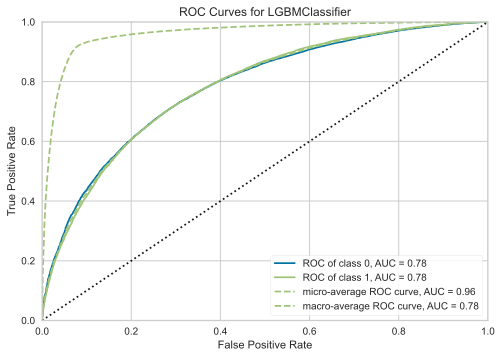

In [ ]:
plot_model(estimator = lgbm_tuned, plot = 'auc')

Finished loading model, total used 186 iterations


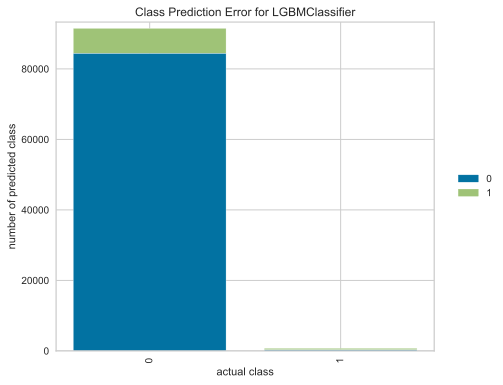

In [ ]:
plot_model(estimator = lgbm_tuned, plot = 'error')

Finished loading model, total used 186 iterations


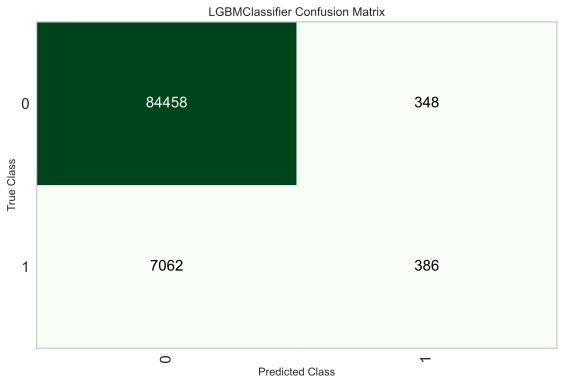

In [ ]:
plot_model(estimator = lgbm_tuned, plot = 'confusion_matrix')

Finished loading model, total used 186 iterations


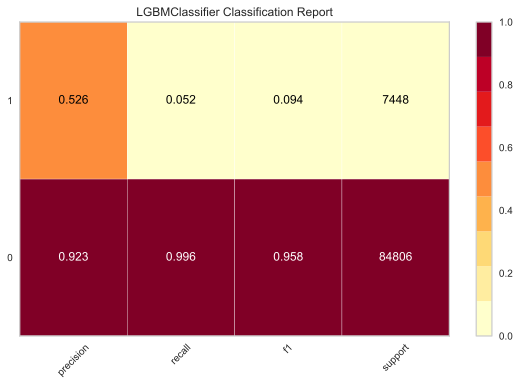

In [ ]:
plot_model(estimator = lgbm_tuned, plot = 'class_report')

##### Résultats

In [ ]:
print(lgbm)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=6711, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [ ]:
print(lgbm_tuned) #hyperopt

LGBMClassifier(bagging_fraction=0.6945224650558043, bagging_freq=5,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.852638862446071, importance_type='split',
               learning_rate=0.051884198516504124, max_depth=-1,
               min_child_samples=38, min_child_weight=0.001,
               min_split_gain=0.45315406842756056, n_estimators=186, n_jobs=-1,
               num_leaves=235, objective=None, random_state=6711,
               reg_alpha=0.018747268421684695, reg_lambda=6.420358403634438e-06,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


In [ ]:
print(lgbm_tuned_optuna)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=6711, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


##### Sauvegarde des modèles lgbm optimisés par pycaret (hyperopt et optuna)

In [ ]:
#Utilisation de JobLib pour sérialiser et enregistrer les modèles lgbm optimisés
from joblib import dump, load
# save model lgbm tuned with hyperopt to disk
dump(lgbm_tuned , 'lgbm_tuned_hyperopt.joblib', compress=1)
# save model lgbm tuned with optuna to disk
dump(lgbm_tuned_optuna, 'lgbm_tuned_optuna.joblib', compress=1)

['lgbm_tuned_optuna.joblib']

In [ ]:
# optimize threshold for trained model
optimize_threshold(lgbm_tuned, true_negative = 1500, false_negative = -5000)

Optimized Probability Threshold: 0.2417 | Optimized Cost Function: 93958500


0.2417

## <span class="bg-info"> 3. Meilleurs modèles : optimisation<span> 

### <span class="bg-warning"> 3.1  Séparation du jeu d'entrainement en entrainement puis validation<span> 

On sépare le jeu de données "train" en X_train et X_valid.

X_train sera utilisé (avec cross-validation) pour:
- Trouver le __meilleur modèle__
- __Optimiser__ les hyperparamètres.

X_valid sera utilisé pour évaluer les __performances__ des meilleurs modèles.

In [ ]:
Y_train = train['TARGET']
data_train = train.drop('TARGET', axis=1)
X_test = test

In [ ]:
# On sépare le jeu d'entrainement en entrainement et validation
X_train, X_valid, y_train, y_valid = train_test_split(data_train,
                                                      Y_train,
                                                      test_size=0.2,
                                                      shuffle=True,
                                                      stratify=Y_train,
                                                      random_state=42)

In [ ]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((246008, 108), (61503, 108), (246008,), (61503,))

In [ ]:
y_train.value_counts(normalize=True)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

In [ ]:
y_valid.value_counts(normalize=True)

0    0.919272
1    0.080728
Name: TARGET, dtype: float64

### <span class="bg-warning"> 3.2 Réquilibrage de la cible : SMOTE<span> 

In [ ]:
# Réquilibrage de la cible
# Note : sampling_strategy=0.2, the ratio peut-être choisi

from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy='auto', k_neighbors=5, n_jobs=-1,
           random_state=14)  #'minority'

X_train_SMOTE, y_train_SMOTE = sm.fit_resample(X_train, y_train)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_train_SMOTE.shape, y_train_SMOTE.shape)

(246008, 108) (246008,)
(452296, 108) (452296,)


In [ ]:
y_train_SMOTE.value_counts(normalize=True)

0    0.5
1    0.5
Name: TARGET, dtype: float64

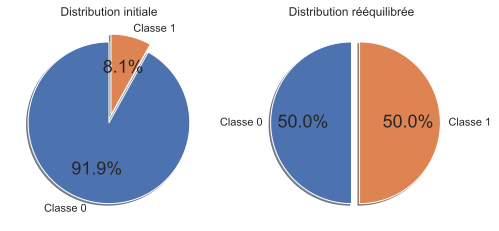

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Distribution initiale')
target_count = y_train.value_counts()
plt.pie(target_count,
        explode=[0, 0.1],
        labels=["Classe 0", "Classe 1"],
        autopct='%1.1f%%',
        shadow=True,
        startangle=90)

plt.subplot(122)
plt.title('Distribution rééquilibrée')
target_count = y_train_SMOTE.value_counts()
plt.pie(target_count,
        explode=[0, 0.1],
        labels=["Classe 0", "Classe 1"],
        autopct='%1.1f%%',
        shadow=True,
        startangle=90)

plt.show()

(500, 108) (500, 2)
0    0.928
1    0.072
Name: TARGET, dtype: float64


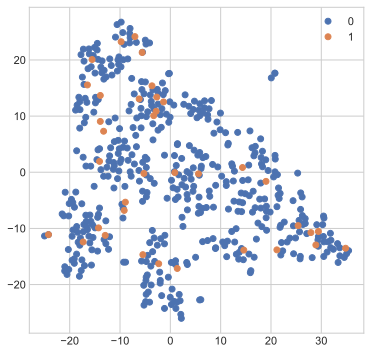

In [ ]:
ind_samp = X_train.sample(500).index
X_train_plot = X_train.loc[ind_samp]
y_train_plot = y_train.loc[ind_samp].reset_index()
print(X_train_plot.shape, y_train_plot.shape)
print(y_train_plot.TARGET.value_counts(normalize=True))
tsne = TSNE(
    n_components=2,
    verbose=0,
)
tsne_df_results = tsne.fit_transform(X_train_plot)
tsne_df = pd.DataFrame(tsne_df_results, columns=[0, 1])
tsne_df['target'] = y_train_plot.TARGET
groups = tsne_df.groupby("target")
plt.figure(figsize=(6, 6))
for name, group in groups:
    plt.plot(group[0], group[1], marker="o", linestyle="", label=name)
plt.legend()
plt.show()

(500, 108) (500, 2)
1    0.502
0    0.498
Name: TARGET, dtype: float64


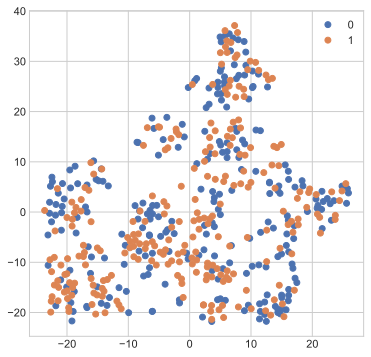

In [ ]:
ind_samp = X_train_SMOTE.sample(500).index
X_train_SMOTE_plot = X_train_SMOTE.loc[ind_samp]
y_train_SMOTE_plot = y_train_SMOTE.loc[ind_samp].reset_index()
print(X_train_SMOTE_plot.shape, y_train_SMOTE_plot.shape)
print(y_train_SMOTE_plot.TARGET.value_counts(normalize=True))
tsne = TSNE(
    n_components=2,
    verbose=0,
)
tsne_df_results = tsne.fit_transform(X_train_SMOTE_plot)
tsne_df = pd.DataFrame(tsne_df_results, columns=[0, 1])
tsne_df['target'] = y_train_SMOTE_plot.TARGET
groups = tsne_df.groupby("target")
plt.figure(figsize=(6, 6))
for name, group in groups:
    plt.plot(group[0], group[1], marker="o", linestyle="", label=name)
plt.legend()
plt.show()

### <span class="bg-warning"> 3.3 Problématique métier : métrique "bancaire" et seuil de solvabilité<span> 

Dans notre problème de classification binaire, le coût des __faux positifs__ n'est pas le même que celui des __faux négatifs__.  (erreurs de type 1 et de type 2)

Nous pouvons optimiser notre classificateur pour une __valeur seuil de probabilité__ afin d'optimiser la fonction de perte personnalisée simplement en définissant le coût des vrais positifs, des vrais négatifs, des faux positifs et des faux négatifs séparément. 

Nous allons d'abord :
- Créer une __métrique "bancaire"__ qui pénalisera les __faux négatifs__, c'est à dire les clients prédits non défaillants par le modèle et qui se révèlent en réalité défaillants.
- chercher et fixer le seuil de solvabilité optimum en fonction de notre métrique bancaire.

#### <span class="bg-success"> 3.3.1 Métrique "bancaire"<span>  

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
# Métrique permettant de pénaliser les faux-négatifs

def bank_metric(y_true, y_pred, rate_tn=1, rate_fp=0, rate_fn=-10, rate_tp=0):
    # Matrice de Confusion
    # tn: true neg, fl:false pos, fn : false neg, true pos
    (tn, fp, fn, tp) = confusion_matrix(y_true, y_pred).ravel()
    # Gain total
    gain_tot = tn * rate_tn + fp * rate_fp + fn * rate_fn + tp * rate_tp
    # Gain maximum
    gain_max = (fp + tn) * rate_tn + (fn + tp) * rate_tp
    # Gain minimum
    gain_min = (fp + tn) * rate_fp + (fn + tp) * rate_fn
    
    # Gain normalisé (entre 0 et 1) Greater is better
    return (gain_tot - gain_min) / (gain_max - gain_min)

In [ ]:
# Création de nos métriques
bank_score = make_scorer(bank_metric, greater_is_better=True)
precision = make_scorer(precision_score, greater_is_better=True)
recall = make_scorer(recall_score, greater_is_better=True)
f1_scorer = make_scorer(fbeta_score, beta=1, greater_is_better=True)
fbeta5_scorer = make_scorer(fbeta_score, beta=5, greater_is_better=True)
roc_auc = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

#### <span class="bg-success"> 3.3.2 Seuil de solvabilité<span>  

In [ ]:
def seuil_solvabilité(clf, y_valid, x_valid, title, n=1):
    """
    Gain en fonction du seuil de solvabilité 
    Client solvable : score < seuil  
    Client non solvable : score > seuil
    
    """
    fonction_cout = []
    seuils = np.linspace(0.0, 1, 20)

    for seuil in seuils:

        # Score du modèle : n = 0 ou 1
        y_score = clf.predict_proba(x_valid)[:, n]

        # Score > seuil de solvabilité : retourne 1 sinon 0
        y_pred = (y_score > seuil)
        y_pred = np.array(y_pred > 0) * 1

        # Calcul de l'indice bancaire
        fonction_cout.append(bank_metric(y_valid, y_pred))

    # Affichage du gain en fonction du seuil de solvabilité
    plt.figure(figsize=(12, 6))
    plt.plot(seuils, fonction_cout)
    plt.xlabel("Seuil de probabilité")
    plt.ylabel("Métrique bancaire")
    plt.title(title)
    plt.xticks(np.linspace(0.1, 1, 10))

#### <span class="bg-success"> 3.3.3 Fonctions utiles à l'optimisation et à l'évaluation<span>  

In [ ]:
###########################   Optimisation   ##########################

#https://github.com/lmassaron/kaggledays-2019-gbdt/blob/master/Kaggle%20Days%20Paris%20-%20Skopt%20%2B%20CatBoost%20solution.ipynb
# Reporting util for different optimizers
def report_perf(optimizer, X, y, title, callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    if callbacks:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           +u"\u00B1"+" %.3f") % (time() - start, 
                                  len(optimizer.cv_results_['params']),
                                  best_score,
                                  best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

In [ ]:
#################   Scores dans différentes métriques ###################

def calcul_scores(y_true,
                  y_pred,
                  y_proba,
                  title,
                  metrics=[
                      'recall_score', 'precision_score', 'f1_score',
                      'f5_score', 'roc_auc_score', 'bank_metric'
                  ]):

    if y_proba is None:
        metrics = [sc for sc in metrics if sc not in ['roc_auc_score']]

    # Dictionnaire des scores
    dict_score = {
        'recall_score': (recall_score, (y_true, y_pred)),
        'precision_score': (precision_score, (y_true, y_pred)),
        'f1_score': (f1_score, (y_true, y_pred)),
        'f5_score': (fbeta_score, (y_true, y_pred, 5)),
        'roc_auc_score': (roc_auc_score, (y_true, y_proba)),
        'bank_metric': (bank_metric, (y_true, y_pred))
    }
    # Liste des scores
    scores = []
    for metric in metrics:
        scores.append(dict_score[metric][0](*dict_score[metric][1]))

    # Table des résultats
    df = pd.DataFrame(scores, index=[metrics], columns=[title])

    return df


In [ ]:
###################       Print Confusion Matrix      ####################

def plot_matrice_confusion(y_true, y_pred, title):
    plt.figure()
    cm = confusion_matrix(y_true, y_pred)
    labels = ['Non défaillants', 'Défaillants']
    plt.figure(figsize=(8, 4))
    sns.set(font_scale=1.8)
    sns.heatmap(cm,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d',
                cmap="Blues",
                vmin=0.2)
    plt.title(f'Confusion Matrix {title}')
    plt.ylabel('Classe réelle')
    plt.xlabel('Classe prédite')
    plt.show()
    

## <span class="bg-info"> 4 Modèle : CATBOOST<span> 

https://www.kaggle.com/shivampanwar/catboost-and-hyperparameter-tuning-using-bayes

### <span class="bg-warning"> 4.1 Modèle de base CATBOOST: hyperparamètres par défaut<span>  

In [ ]:
# Modèle
base_model_catboost = CatBoostClassifier(verbose=False)
# Train
base_model_catboost.fit(X_train, y_train)
# Prédiction
y_pred = base_model_catboost.predict(X_valid)
y_proba = base_model_catboost.predict_proba(X_valid)[:, 1]
# Score
calcul_scores(y_valid, y_pred, y_proba, title='base_model_catboost')

,base_model_catboost
recall_score,0.054985
precision_score,0.528046
f1_score,0.099599
f5_score,0.056947
roc_auc_score,0.792318
bank_metric,0.555844


<Figure size 864x576 with 0 Axes>

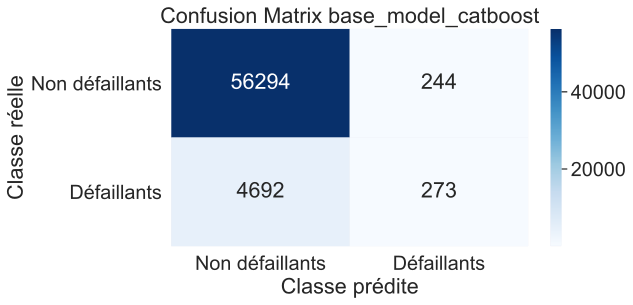

In [ ]:
plot_matrice_confusion(y_valid, y_pred, 'base_model_catboost')

### <span class="bg-warning"> 4.2 Modèle optimisé CATBOOST: optimisation bayésienne des hyperparamètres (Scikit-Optimize)<span> 
    
#### Scikit-Optimize

tuning catboost doc officielle https://catboost.ai/docs/concepts/parameter-tuning.html

#### <span class="bg-success">4.2.1 Optimisation sur la métrique 'roc_auc'<span>

In [ ]:
# Modèle catboost
clf = CatBoostClassifier(thread_count=7,
                         loss_function='Logloss',
                         od_type='Iter',
                         verbose=False)

##### Recherche des meilleurs hyperparamètres

In [ ]:
# Espaces de recherches
search_spaces = {
    'iterations': Integer(10, 1000),
    'depth': Integer(1, 8),
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),
    'border_count': Integer(1, 255),
    'random_strength': Real(1e-9, 10, 'log-uniform'),
    'bagging_temperature': Real(0.0, 1.0),
    'l2_leaf_reg': Integer(2, 30),
    'scale_pos_weight': Real(0.01, 1.0, 'uniform')
}

In [ ]:
# Mise en place de BayesSearchCV
opt = BayesSearchCV(
    clf,
    search_spaces,
    scoring=roc_auc,
    cv=skf,
    n_iter=100,
    return_train_score=False,
    refit=True,
    optimizer_kwargs={'base_estimator': 'GP'},
    random_state=42)

In [ ]:
# Recherche des meilleurs hyperparamètres
best_params = report_perf(
    opt,
    X_train,
    y_train,
    'CatBoost',
    callbacks=[VerboseCallback(100),
               DeadlineStopper(60 * 10)])
# 10 minutes max

Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 105.0919
Function value obtained: -0.7871
Current minimum: -0.7871
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 139.7372
Function value obtained: -0.7758
Current minimum: -0.7871
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 55.5145
Function value obtained: -0.7814
Current minimum: -0.7871
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 146.1700
Function value obtained: -0.7824
Current minimum: -0.7871
Iteration No: 5 started. Searching for the next optimal point.
Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 124.1639
Function value

In [ ]:
# Dictionnaire des meilleurs hyperparamètres
best_params = {
    'bagging_temperature': 0.41010395885331385,
    'border_count': 254,  #CPU
    'depth': 8,
    'iterations': 323,
    'l2_leaf_reg': 21,
    'learning_rate': 0.0673344419215237,
    'random_strength': 3.230824361824754e-06,
    'scale_pos_weight': 0.7421091918485163
}
best_params['iterations'] = 1000

##### Prédictions - Score

La durée d'exécution de Catboost:  0:01:22.877305


,catboost_tuned_roc_auc
recall_score,0.030413
precision_score,0.580769
f1_score,0.057799
f5_score,0.031563
roc_auc_score,0.793667
bank_metric,0.545627


<Figure size 864x576 with 0 Axes>

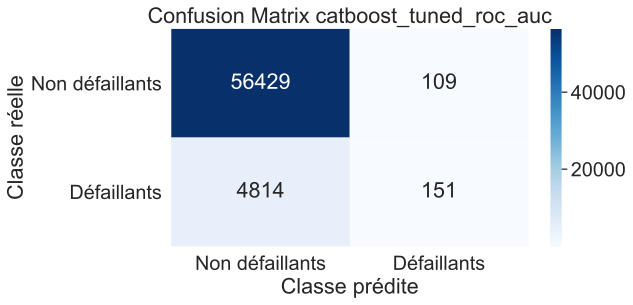

In [ ]:
# Mesure durée d'exécution
start = datetime.now()

# Modèle CATBOOST optimisé
catboost_tuned_roc_auc = CatBoostClassifier(
    **best_params,
    task_type="CPU",
    verbose=False,
)
# Train
catboost_tuned_roc_auc.fit(X_train, y_train)

stop = datetime.now()
execution_time_catboost = stop - start
print("La durée d'exécution de Catboost: ", execution_time_catboost)

# Prédictions
y_pred = catboost_tuned_roc_auc.predict(X_valid)
y_proba = catboost_tuned_roc_auc.predict_proba(X_valid)[:, 1]

# Score
display(calcul_scores(y_valid, y_pred, y_proba, title='catboost_tuned_roc_auc'))

# Matrice de confusion
plot_matrice_confusion(y_valid, y_pred, title='catboost_tuned_roc_auc')
plt.show()

In [ ]:
#cross validate
scoring = ['roc_auc', 'recall', 'precision']
scores = cross_validate(catboost_tuned_roc_auc , X_train, y_train, cv=5,
                        scoring=scoring, return_train_score=True)

# report performance
pd.DataFrame(scores).T;

#### <span class="bg-success">4.2.2 Optimisation sur la métrique 'bank_score' créée par nos soins<span>

In [ ]:
# Modèle catboost
clf = CatBoostClassifier(thread_count=7,
                         loss_function='Logloss',
                         od_type='Iter',
                         verbose=False)

##### Recherche des meilleurs hyperparamètres

In [ ]:
# Espaces de recherches
search_spaces = {
    'iterations': Integer(10, 1000),
    'depth': Integer(1, 8),
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),
    'random_strength': Real(1e-9, 10, 'log-uniform'),
    'bagging_temperature': Real(0.0, 1.0),
    'border_count': Integer(1, 255),
    'l2_leaf_reg': Integer(2, 30),
    'scale_pos_weight': Real(0.01, 1.0, 'uniform')
}

In [ ]:
# Mise en place de BayesSearchCV
opt = BayesSearchCV(
    clf,
    search_spaces,
    scoring=bank_score,
    cv=skf,
    n_iter=100,
    n_jobs=
    1,  # use just 1 job with CatBoost in order to avoid segmentation fault
    return_train_score=False,
    refit=True,
    optimizer_kwargs={'base_estimator': 'GP'},
    random_state=42)

In [ ]:
# Recherche des meilleurs hyperparamètres
best_params = report_perf(
    opt,
    X_train,
    y_train,
    'CatBoost',
    callbacks=[VerboseCallback(100),
               DeadlineStopper(60 * 10)])

Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 124.0701
Function value obtained: -0.5400
Current minimum: -0.5400
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 164.3264
Function value obtained: -0.5325
Current minimum: -0.5400
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 65.4719
Function value obtained: -0.5374
Current minimum: -0.5400
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 174.6678
Function value obtained: -0.5376
Current minimum: -0.5400
Iteration No: 5 started. Searching for the next optimal point.
CatBoost took 556.71 seconds,  candidates checked: 4, best CV score: 0.540 ± 0.000
Best parameters:
Or

In [ ]:
# Dictionnaire des meilleurs hyperparamètres
best_params = {
    'bagging_temperature': 0.7995534416071731,
    'border_count': 254,  #CPU
    'depth': 5,
    'iterations': 1000,
    'l2_leaf_reg': 27,
    'learning_rate': 0.27168289873702833,
    'random_strength': 1.744940909365023e-05,
    'scale_pos_weight': 0.653781260730285
}

##### Prédictions - Score

La durée d'exécution de Catboost:  0:00:49.057771


,catboost_tuned_bank_metric
recall_score,0.039476
precision_score,0.555241
f1_score,0.073712
f5_score,0.040939
roc_auc_score,0.787896
bank_metric,0.549412


<Figure size 864x576 with 0 Axes>

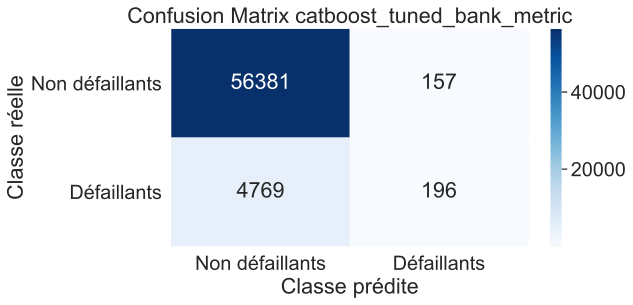

In [ ]:
# Mesure durée d'exécution
start = datetime.now()

# Modèle CATBOOST optimisé bank_metric
catboost_tuned_bank_metric = CatBoostClassifier(
    **best_params, task_type="CPU", verbose=False,
    od_type='Iter')  #Détecteur overfitting
# Train
catboost_tuned_bank_metric.fit(X_train, y_train)

stop = datetime.now()
execution_time_catboost = stop - start
print("La durée d'exécution de Catboost: ", execution_time_catboost)

# Prédictions
y_pred = catboost_tuned_bank_metric.predict(X_valid)
y_proba = catboost_tuned_bank_metric.predict_proba(X_valid)[:, 1]

# Score
display(
    calcul_scores(y_valid, y_pred, y_proba, title='catboost_tuned_bank_metric'))

plot_matrice_confusion(y_valid, y_pred, title='catboost_tuned_bank_metric')
plt.show()

In [ ]:
#cross validate
scoring = ['roc_auc', 'recall', 'precision']
scores = cross_validate(catboost_tuned_bank_metric , X_train, y_train, cv=5,
                        scoring=scoring, return_train_score=True)

# report performance
pd.DataFrame(scores).T;

## <span class="bg-info"> 5 Modèle : LightGBM<span> 

### <span class="bg-warning"> 5.1 Modèle de base LGBM: hyperparamètres par défaut<span>  

In [ ]:
# Modèle
base_model_lgbm = LGBMClassifier(verbose=0)
# Train
base_model_lgbm.fit(X_train, y_train)
# Prédiction
y_pred = base_model_lgbm.predict(X_valid)
y_proba = base_model_lgbm.predict_proba(X_valid)[:, 1]
# Score
calcul_scores(y_valid, y_pred, y_proba, title='base_model_lgbm')

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080481 seconds.
You can set `force_col_wise=true` to remove the overhead.


,base_model_lgbm
recall_score,0.033233
precision_score,0.557432
f1_score,0.062726
f5_score,0.034480
roc_auc_score,0.789138
bank_metric,0.546738


In [ ]:
#cross validate
scoring = ['roc_auc', 'recall', 'precision']
scores = cross_validate(base_model_lgbm , X_train, y_train, cv=5,
                        scoring=scoring, return_train_score=True)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057230 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [ ]:
# report performance
pd.DataFrame(scores).T

,0,1,2,3,4
fit_time,3.124853,3.237561,3.344450,3.432634,3.326539
score_time,0.243924,0.240748,0.289626,0.280071,0.250540
test_roc_auc,0.791352,0.774734,0.787404,0.785357,0.783880
train_roc_auc,0.839045,0.841341,0.841206,0.841711,0.840859
test_recall,0.030211,0.033736,0.031470,0.032477,0.035247
train_recall,0.054381,0.056961,0.051989,0.051108,0.055828
test_precision,0.521739,0.531746,0.529661,0.583710,0.564516
train_precision,0.786885,0.802305,0.776316,0.786060,0.776028


<Figure size 864x576 with 0 Axes>

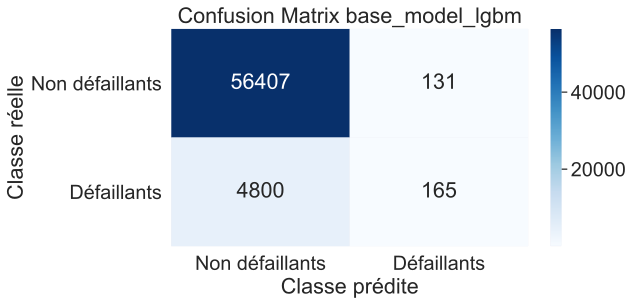

In [ ]:
plot_matrice_confusion(y_valid, y_pred, 'base_model_lgbm')

### <span class="bg-warning"> 5.2 Modèle optimisé LGBM: optimisation bayésienne des hyperparamètres (Scikit-Optimize)<span> 
    
#### Scikit-Optimize

 tuning LightGBM doc officielle https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

#### <span class="bg-success">5.2.1 Optimisation sur la métrique 'roc_auc'<span>

In [ ]:
# Modèle lgbm
clf = LGBMClassifier(objective='binary')

##### Recherche des meilleurs hyperparamètres

In [ ]:
# Espaces de recherches
search_spaces = {
    'boosting_type' : ['gbdt', 'dart', 'goss'],
    'num_leaves': Integer(25, 50),
    'max_depth': Integer(6, 11),
    'min_split_gain' : Real(0, 0.1),
    'min_child_weight' : Integer(5,80),
    'min_child_samples' : Integer(5,80),
    'colsample_bytree' : Real(0.5,1),
    'reg_alpha' : Real(0.001, 0.3),
    'reg_lambda' : Real(0.001, 0.3),
    'subsample': Real(0.5, 1.0)
}

In [ ]:
# Mise en place de BayesSearchCV
opt = BayesSearchCV(
    clf,
    search_spaces,
    scoring=roc_auc,
    cv=skf,
    n_iter=100,
    n_jobs=1,  
    return_train_score=False,
    refit=True,
    optimizer_kwargs={'base_estimator': 'GP'},
    random_state=42)

In [ ]:
# Recherche des meilleurs hyperparamètres
best_params = report_perf(
    opt,
    X_train,
    y_train,
    'lgbm',
    callbacks=[VerboseCallback(100),
               DeadlineStopper(60 * 10)])
# 10 minutes max

Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 18.8950
Function value obtained: -0.7872
Current minimum: -0.7872
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 16.6984
Function value obtained: -0.7865
Current minimum: -0.7872
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 17.3876
Function value obtained: -0.7860
Current minimum: -0.7872
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 16.2958
Function value obtained: -0.7861
Current minimum: -0.7872
Iteration No: 5 started. Searching for the next optimal point.
Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 16.0379
Function value obt

OrderedDict([('boosting_type', 'gbdt'),
             ('colsample_bytree', 1.0),
             ('max_depth', 11),
             ('min_child_samples', 80),
             ('min_child_weight', 29),
             ('min_split_gain', 0.1),
             ('num_leaves', 50),
             ('reg_alpha', 0.001),
             ('reg_lambda', 0.3),
             ('subsample', 1.0)])

In [ ]:
best_params = {
    'boosting_type' : 'gbdt',
    'num_leaves': 48,
    'max_depth': 11,
    'min_split_gain' : 0.1,
    'min_child_weight' : 80,
    'min_child_samples' : 18,
    'colsample_bytree' : 0.6685976111628331,
    'reg_alpha' : 0.3,
    'reg_lambda' : 0.1509731738366173,
    'subsample': 0.7257255326720535
}

##### Prédictions - Score

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096067 seconds.
You can set `force_col_wise=true` to remove the overhead.
La durée d'exécution de lgbm:  0:00:04.470428


,lgbm_tuned_roc_auc
recall_score,0.700705
precision_score,0.189891
f1_score,0.298806
f5_score,0.635006
roc_auc_score,0.790311
bank_metric,0.720289


<Figure size 864x576 with 0 Axes>

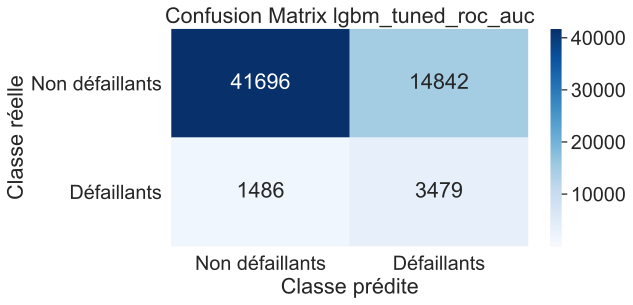

In [ ]:
#### LGBM métrique AUC learning rate et estimateurs par défaut

# Mesure durée d'exécution
start = datetime.now()

# Modèle LGBM optimisé
lgbm_tuned_roc_auc = LGBMClassifier(**best_params,
                                    objective='binary',
                                    class_weight='balanced',
                                    verbose=0)

# Train
lgbm_tuned_roc_auc.fit(X_train, y_train)

stop = datetime.now()
execution_time_lgbm = stop - start
print("La durée d'exécution de lgbm: ", execution_time_lgbm)

# Prédictions
y_pred = lgbm_tuned_roc_auc.predict(X_valid)
y_proba = lgbm_tuned_roc_auc.predict_proba(X_valid)[:, 1]

# Score
display(calcul_scores(y_valid, y_pred, y_proba, title='lgbm_tuned_roc_auc'))

# Matrice de confusion
plot_matrice_confusion(y_valid, y_pred, title='lgbm_tuned_roc_auc')
plt.show()

In [ ]:
#cross validate
scoring = ['roc_auc', 'recall', 'precision']
scores = cross_validate(lgbm_tuned_roc_auc , X_train, y_train, cv=5,
                        scoring=scoring, return_train_score=True)

# report performance
pd.DataFrame(scores).T

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054990 seconds.
You can set `force_col_wise=true` to remove the overhead.


,0,1,2,3,4
fit_time,3.466422,3.510535,3.668392,3.460039,3.545514
score_time,0.280614,0.273069,0.308720,0.293820,0.312206
test_roc_auc,0.791887,0.775167,0.787822,0.788872,0.787071
train_roc_auc,0.852946,0.855763,0.853372,0.853325,0.853523
test_recall,0.698640,0.668681,0.688570,0.693857,0.685549
train_recall,0.794877,0.800038,0.795569,0.798024,0.796135
test_precision,0.191393,0.182832,0.187714,0.187534,0.188953
train_precision,0.217311,0.218676,0.217163,0.215369,0.217688


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

,lgbm_tuned_roc_auc
recall_score,0.603827
precision_score,0.223865
f1_score,0.326633
f5_score,0.566824
roc_auc_score,0.791848
bank_metric,0.716879


<Figure size 864x576 with 0 Axes>

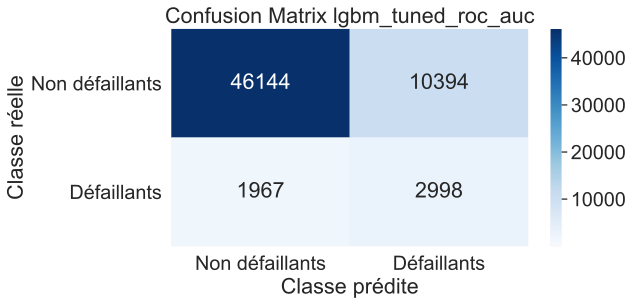

In [ ]:
#### LGBM métrique AUC learning rate 0.005 et estimateurs 10 000

# Mesure durée d'exécution
start = datetime.now()

# Modèle LGBM optimisé
lgbm_tuned_roc_auc = LGBMClassifier(**best_params,
                                    objective='binary',
                                    learning_rate=0.005,
                                    n_estimators=10000,
                                    class_weight='balanced',
                                    verbose=0)

# Train
lgbm_tuned_roc_auc.fit(X_train, y_train)

stop = datetime.now()
execution_time_lgbm = stop - start
print("La durée d'exécution de lgbm: ", execution_time_lgbm)

# Prédictions
y_pred = lgbm_tuned_roc_auc.predict(X_valid)
y_proba = lgbm_tuned_roc_auc.predict_proba(X_valid)[:, 1]

# Score
display(calcul_scores(y_valid, y_pred, y_proba, title='lgbm_tuned_roc_auc'))

# Matrice de confusion
plot_matrice_confusion(y_valid, y_pred, title='lgbm_tuned_roc_auc')
plt.show()

In [ ]:
#cross validate
scoring = ['roc_auc', 'recall', 'precision']
scores = cross_validate(lgbm_tuned_roc_auc , X_train, y_train, cv=5,
                        scoring=scoring, return_train_score=True)

# report performance
pd.DataFrame(scores).T

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

,0,1,2,3,4
fit_time,179.790987,184.115200,192.640738,184.220284,179.586697
score_time,28.951751,27.915110,29.620246,27.388380,26.646545
test_roc_auc,0.793388,0.776490,0.788218,0.788605,0.788765
train_roc_auc,0.962122,0.963249,0.962814,0.962669,0.963196
test_recall,0.577543,0.550604,0.573263,0.580564,0.566465
train_recall,0.957012,0.960536,0.959718,0.957641,0.960536
test_precision,0.232186,0.219094,0.227427,0.228475,0.227526
train_precision,0.369987,0.371458,0.371712,0.369907,0.373084


#### <span class="bg-success">5.2.2 Optimisation sur la métrique 'bank_score' créée par nos soins<span>

In [ ]:
# Modèle lgbm
clf = LGBMClassifier(objective='binary')

##### Recherche des meilleurs hyperparamètres

In [ ]:
# Espaces de recherches
search_spaces = {
    'boosting_type' : ['gbdt', 'dart', 'goss'],
    'num_leaves': Integer(25, 50),
    'max_depth': Integer(6, 11),
    'min_split_gain' : Real(0, 0.1),
    'min_child_weight' : Integer(5,80),
    'min_child_samples' : Integer(5,80),
    'colsample_bytree' : Real(0.5,1),
    'reg_alpha' : Real(0.001, 0.3),
    'reg_lambda' : Real(0.001, 0.3),
    'subsample': Real(0.5, 1.0)
}

In [ ]:
# Mise en place de BayesSearchCV
opt = BayesSearchCV(
    clf,
    search_spaces,
    scoring=bank_score,
    cv=skf,
    n_iter=100,
    return_train_score=False,
    refit=True,
    optimizer_kwargs={'base_estimator': 'GP'},
    random_state=42)

In [ ]:
# Recherche des meilleurs hyperparamètres
best_params = report_perf(
    opt,
    X_train,
    y_train,
    'lgbm_bank_metric',
    callbacks=[VerboseCallback(100),
               DeadlineStopper(120 * 10)])

Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 19.3890
Function value obtained: -0.5478
Current minimum: -0.5478
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 16.2567
Function value obtained: -0.5457
Current minimum: -0.5478
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 17.3534
Function value obtained: -0.5462
Current minimum: -0.5478
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 15.7280
Function value obtained: -0.5470
Current minimum: -0.5478
Iteration No: 5 started. Searching for the next optimal point.
Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 15.7051
Function value obt

Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 23.8770
Function value obtained: -0.5491
Current minimum: -0.5507
Iteration No: 41 started. Searching for the next optimal point.
Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 21.9228
Function value obtained: -0.5497
Current minimum: -0.5507
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 19.1442
Function value obtained: -0.5477
Current minimum: -0.5507
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 16.4649
Function value obtained: -0.5475
Current minimum: -0.5507
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 17.2529
Function value obtained: -0.5485
Current minimum: -0.5507
Iteration No: 

In [ ]:
# Dictionnaire des meilleurs hyperparamètres
best_params = {
    'boosting_type' : 'gbdt',
    'num_leaves': 50,
    'max_depth': 11,
    'min_split_gain' : 0.0,
    'min_child_weight' : 5,
    'min_child_samples' : 5,
    'colsample_bytree' : 1.0,
    'reg_alpha' : 0.3,
    'reg_lambda' : 0.001,
    'subsample': 1.0
}

##### Prédictions - Score

La durée d'exécution de lgbm:  0:00:04.857193


,lgbm_tuned_bank_metric
recall_score,0.701712
precision_score,0.189916
f1_score,0.298927
f5_score,0.635811
roc_auc_score,0.789613
bank_metric,0.720580


<Figure size 864x576 with 0 Axes>

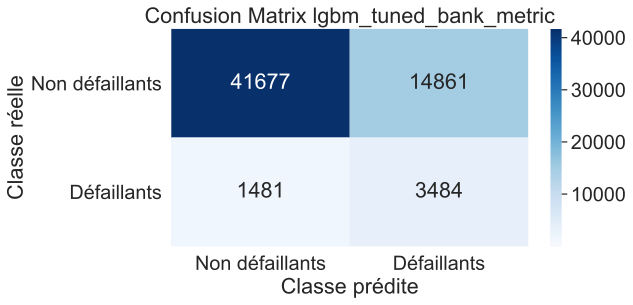

In [ ]:
#### LGBM métrique bancaire learning rate et estimateurs par défaut

# Mesure durée d'exécution
start = datetime.now()

# Modèle LightGBM optimisé bank_metric
lgbm_tuned_bank_metric = LGBMClassifier(**best_params,
                                        objective='binary',
                                        force_col_wise=True,
                                        class_weight ='balanced',
                                        verbose=0)

# Train
lgbm_tuned_bank_metric.fit(X_train, y_train)

stop = datetime.now()
execution_time_lgbm = stop - start
print("La durée d'exécution de lgbm: ", execution_time_lgbm)

# Prédictions
y_pred = lgbm_tuned_bank_metric.predict(X_valid)
y_proba = lgbm_tuned_bank_metric.predict_proba(X_valid)[:, 1]

# Score
display(calcul_scores(y_valid, y_pred, y_proba,
                      title='lgbm_tuned_bank_metric'))

# Matrice de confusion
plot_matrice_confusion(y_valid, y_pred, title='lgbm_tuned_bank_metric')
plt.show()

In [ ]:
#cross validate
scoring = ['roc_auc', 'recall', 'precision']
scores = cross_validate(lgbm_tuned_bank_metric , X_train, y_train, cv=5,
                        scoring=scoring, return_train_score=True)

# report performance
pd.DataFrame(scores).T

,0,1,2,3,4
fit_time,4.782714,4.199000,4.148942,4.338753,4.077866
score_time,0.272708,0.270541,0.280735,0.280578,0.280573
test_roc_auc,0.791154,0.775711,0.786428,0.786720,0.783708
train_roc_auc,0.861842,0.864732,0.862763,0.861648,0.862224
test_recall,0.693102,0.663394,0.688066,0.692346,0.680765
train_recall,0.805010,0.811241,0.807024,0.807087,0.806269
test_precision,0.192774,0.184446,0.189423,0.188369,0.189714
train_precision,0.222238,0.224281,0.222569,0.219122,0.222790


La durée d'exécution de lgbm:  0:00:44.541729


,lgbm_tuned_bank_metric
recall_score,0.458207
precision_score,0.247794
f1_score,0.321646
f5_score,0.443716
roc_auc_score,0.770121
bank_metric,0.681640


<Figure size 864x576 with 0 Axes>

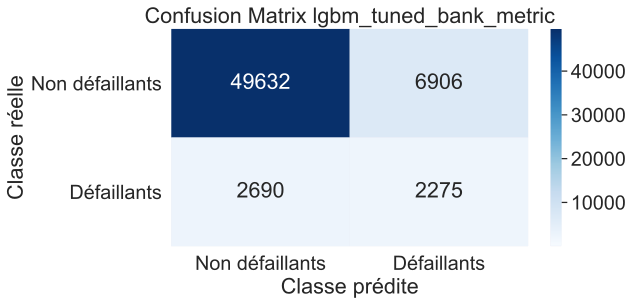

In [ ]:
##############     LGBM métrique bancaire learning rate 0.05 et estimateurs 2000    #############

# Mesure durée d'exécution
start = datetime.now()

# Modèle LightGBM optimisé bank_metric
lgbm_tuned_bank_metric = LGBMClassifier(**best_params,
                                        objective='binary',
                                        learning_rate=0.05,
                                        n_estimators=2000,
                                        force_col_wise=True,
                                        class_weight ='balanced',
                                        verbose=0)

# Train
lgbm_tuned_bank_metric.fit(X_train, y_train)

stop = datetime.now()
execution_time_lgbm = stop - start
print("La durée d'exécution de lgbm: ", execution_time_lgbm)

# Prédictions
y_pred = lgbm_tuned_bank_metric.predict(X_valid)
y_proba = lgbm_tuned_bank_metric.predict_proba(X_valid)[:, 1]

# Score
display(calcul_scores(y_valid, y_pred, y_proba,
                      title='lgbm_tuned_bank_metric'))

# Matrice de confusion
plot_matrice_confusion(y_valid, y_pred, title='lgbm_tuned_bank_metric')
plt.show()

In [ ]:
#cross validate
scoring = ['roc_auc', 'recall', 'precision']
scores = cross_validate(lgbm_tuned_bank_metric , X_train, y_train, cv=5,
                        scoring=scoring, return_train_score=True)

# report performance
pd.DataFrame(scores).T

,0,1,2,3,4
fit_time,37.632493,37.332822,37.653179,38.152333,38.444710
score_time,2.077229,1.956496,1.958797,1.968778,1.976641
test_roc_auc,0.769183,0.752246,0.765408,0.766055,0.763518
train_roc_auc,0.995645,0.995987,0.996027,0.996002,0.995871
test_recall,0.395015,0.387714,0.392497,0.410121,0.396022
train_recall,0.988419,0.989426,0.990181,0.989174,0.990307
test_precision,0.255246,0.247987,0.253785,0.259395,0.257320
train_precision,0.598772,0.599337,0.599291,0.601155,0.598638


La durée d'exécution de lgbm:  0:04:01.537553


,lgbm_tuned_bank_metric
recall_score,0.575227
precision_score,0.224211
f1_score,0.322657
f5_score,0.542557
roc_auc_score,0.785072
bank_metric,0.708329


<Figure size 864x576 with 0 Axes>

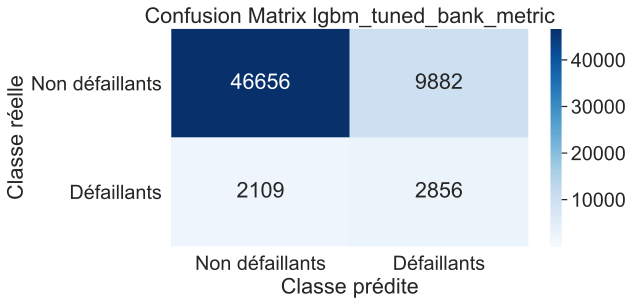

In [ ]:
#### LGBM métrique bancaire learning rate 0.005 et estimateurs 10 000

# Mesure durée d'exécution
start = datetime.now()

# Modèle LightGBM optimisé bank_metric
lgbm_tuned_bank_metric = LGBMClassifier(**best_params,
                                        objective='binary',
                                        learning_rate=0.005,
                                        n_estimators=10000,
                                        force_col_wise=True,
                                        class_weight ='balanced',
                                        verbose=0)

# Train
lgbm_tuned_bank_metric.fit(X_train, y_train)

stop = datetime.now()
execution_time_lgbm = stop - start
print("La durée d'exécution de lgbm: ", execution_time_lgbm)

# Prédictions
y_pred = lgbm_tuned_bank_metric.predict(X_valid)
y_proba = lgbm_tuned_bank_metric.predict_proba(X_valid)[:, 1]

# Score
display(calcul_scores(y_valid, y_pred, y_proba,
                      title='lgbm_tuned_bank_metric'))

# Matrice de confusion
plot_matrice_confusion(y_valid, y_pred, title='lgbm_tuned_bank_metric')
plt.show()

In [ ]:
#cross validate
scoring = ['roc_auc', 'recall', 'precision']
scores = cross_validate(lgbm_tuned_bank_metric , X_train, y_train, cv=5,
                        scoring=scoring, return_train_score=True)

# report performance
pd.DataFrame(scores).T

,0,1,2,3,4
fit_time,200.559315,198.146376,204.096381,207.499079,199.925653
score_time,23.953943,23.098408,23.949846,23.424839,22.260367
test_roc_auc,0.784033,0.765752,0.779992,0.778756,0.778850
train_roc_auc,0.971568,0.972933,0.971900,0.972670,0.971719
test_recall,0.542800,0.511329,0.545317,0.544058,0.531974
train_recall,0.953424,0.956949,0.954935,0.954872,0.953802
test_precision,0.233333,0.217173,0.228361,0.229527,0.226207
train_precision,0.397418,0.398261,0.393037,0.395562,0.395717


### <span class="bg-warning"> 5.3 Modèle optimisé LGBM: __essai SMOTE__ optimisation bayésienne des hyperparamètres (Scikit-Optimize)<span> 

#### <span class="bg-success">5.3.1 Optimisation sur la métrique 'bank_score' créée par mes soins<span>

In [ ]:
# Modèle lgbm
clf = LGBMClassifier(objective='binary')

##### Recherche des meilleurs hyperparamètres

To deal with over-fitting:
- Use small max_bin
- Use small num_leaves
- Use min_data_in_leaf and min_sum_hessian_in_leaf
- Use bagging by set bagging_fraction and bagging_freq
- Use feature sub-sampling by set feature_fraction

- Try lambda_l1, lambda_l2 and min_gain_to_split to regularization
- Try max_depth to avoid growing deep tree

# Espaces de recherches
search_spaces = {
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),
    'num_leaves': Integer(24, 80),
    'feature_fraction': Real(0.1, 0.9),
    'bagging_fraction': Real(0.8, 1),
    'max_depth': Integer(5, 30),
    'max_bin': Integer(20, 90),
    'min_data_in_leaf': Integer(20, 80),
    'min_sum_hessian_in_leaf': Real(0, 100),
    'subsample': Real(0.01, 1.0)
}

# Espaces de recherches
search_spaces = {
    'num_leaves': Integer(10, 60),
    'feature_fraction': Real(0.1, 0.9),
    'bagging_fraction': Real(0.8, 1),
    'max_depth': Integer(5, 20),
    'max_bin': Integer(20, 60),
    'min_data_in_leaf': Integer(20, 80),
    'min_sum_hessian_in_leaf': Real(0, 100),
    'subsample': Real(0.01, 1.0)
}

In [ ]:
# Espaces de recherches
search_spaces = {
    'num_leaves': Integer(25, 60),
    'max_depth': Integer(-1, 8),
    'min_split_gain' : Real(0, 0.1),
    'min_child_weight' : Integer(5,80),
    'min_child_samples' : Integer(5,80),
    'colsample_bytree' : Real(0.5,1),
    'reg_alpha' : Real(0.001, 0.3),
    'reg_lambda' : Real(0.001, 0.3),
    'subsample': Real(0.5, 1.0)
}

In [ ]:
# Mise en place de BayesSearchCV
opt = BayesSearchCV(
    clf,
    search_spaces,
    scoring=bank_score,
    cv=skf,
    n_iter=100,
    return_train_score=False,
    refit=True,
    optimizer_kwargs={'base_estimator': 'GP'},
    random_state=42)

In [ ]:
# Recherche des meilleurs hyperparamètres
best_params = report_perf(
    opt,
    X_train_SMOTE,
    y_train_SMOTE,
    'lgbm_bank_metric',
    callbacks=[VerboseCallback(100),
               DeadlineStopper(60 * 10)])

Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 25.2048
Function value obtained: -0.9201
Current minimum: -0.9201
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 28.3303
Function value obtained: -0.9194
Current minimum: -0.9201
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 27.5673
Function value obtained: -0.9207
Current minimum: -0.9207
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 14.4954
Function value obtained: -0.8670
Current minimum: -0.9207
Iteration No: 5 started. Searching for the next optimal point.
Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 18.3253
Function value obt

In [ ]:
# Dictionnaire des meilleurs hyperparamètres
best_params = {
    'boosting_type' : 'gbdt',
    'num_leaves': 60,
    'max_depth': 0,
    'min_split_gain' : 0.010836837412299384,
    'min_child_weight' : 80,
    'min_child_samples' : 41,
    'colsample_bytree' : 1.0,
    'reg_alpha' : 0.001,
    'reg_lambda' :  0.001,
    'subsample': 0.9492735997671372
}

##### Prédictions - Score

La durée d'exécution de lgbm:  0:00:11.045940


,lgbm_tuned_SMOTE_bank_metric
recall_score,0.051964
precision_score,0.364922
f1_score,0.090973
f5_score,0.053736
roc_auc_score,0.771924
bank_metric,0.552501


<Figure size 864x576 with 0 Axes>

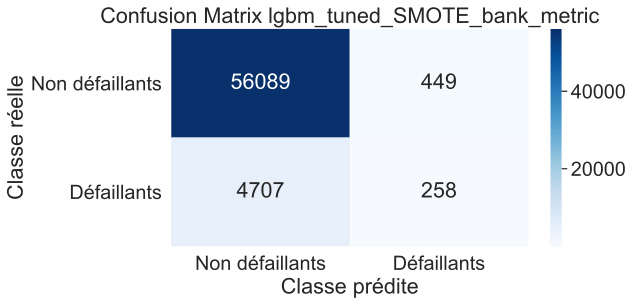

In [ ]:
#### LGBM SMOTE métrique bancaire learning rate et estimateurs par défaut

# Mesure durée d'exécution
start = datetime.now()

# Modèle LightGBM optimisé bank_metric
lgbm_tuned_SMOTE_bank_metric = LGBMClassifier(**best_params,
                                        objective='binary',     
                                        force_col_wise=True,      
                                        verbose=0)

# Train
lgbm_tuned_SMOTE_bank_metric.fit(X_train_SMOTE, y_train_SMOTE)

stop = datetime.now()
execution_time_lgbm = stop - start
print("La durée d'exécution de lgbm: ", execution_time_lgbm)

# Prédictions
y_pred = lgbm_tuned_SMOTE_bank_metric.predict(X_valid)
y_proba = lgbm_tuned_SMOTE_bank_metric.predict_proba(X_valid)[:, 1]

# Score
display(calcul_scores(y_valid, y_pred, y_proba,
                      title='lgbm_tuned_SMOTE_bank_metric'))

# Matrice de confusion
plot_matrice_confusion(y_valid, y_pred, title='lgbm_tuned_SMOTE_bank_metric')
plt.show()

In [ ]:
#cross validate
scoring = ['roc_auc', 'recall', 'precision']
scores = cross_validate(lgbm_tuned_SMOTE_bank_metric , X_train, y_train, cv=5,
                        scoring=scoring, return_train_score=True)

# report performance
pd.DataFrame(scores).T

,0,1,2,3,4
fit_time,5.252089,4.733756,4.875696,5.207385,4.831484
score_time,0.308670,0.300486,0.308838,0.310696,0.335194
test_roc_auc,0.793160,0.777992,0.789738,0.789517,0.786904
train_roc_auc,0.856792,0.858752,0.857217,0.856945,0.857644
test_recall,0.043051,0.043807,0.044562,0.041289,0.041541
train_recall,0.076976,0.078109,0.076473,0.076095,0.073263
test_precision,0.511976,0.535385,0.542945,0.527331,0.578947
train_precision,0.791074,0.798071,0.799342,0.804927,0.808333


La durée d'exécution de lgbm:  0:06:34.919180


,lgbm_tuned_SMOTE_bank_metric
recall_score,0.083787
precision_score,0.438356
f1_score,0.140683
f5_score,0.086477
roc_auc_score,0.763931
bank_metric,0.566589


<Figure size 864x576 with 0 Axes>

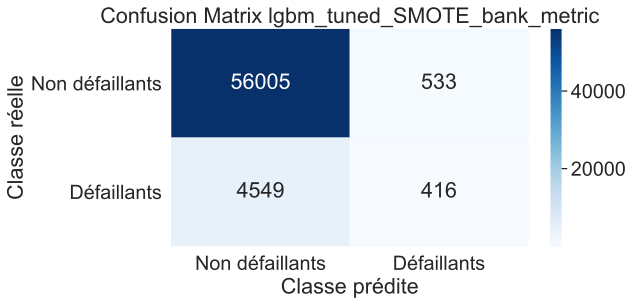

In [ ]:
#### LGBM SMOTE métrique bancaire learning rate 0.05 et estimateurs 5000

# Mesure durée d'exécution
start = datetime.now()

# Modèle LightGBM SMOTE optimisé bank_metric
lgbm_tuned_SMOTE_bank_metric = LGBMClassifier(**best_params,
                                        objective='binary',
                                        learning_rate=0.05,
                                        n_estimators=5000,      
                                        force_col_wise=True,      
                                        verbose=0)

# Train
lgbm_tuned_SMOTE_bank_metric.fit(X_train_SMOTE, y_train_SMOTE)

stop = datetime.now()
execution_time_lgbm = stop - start
print("La durée d'exécution de lgbm: ", execution_time_lgbm)

# Prédictions
y_pred = lgbm_tuned_SMOTE_bank_metric.predict(X_valid)
y_proba = lgbm_tuned_SMOTE_bank_metric.predict_proba(X_valid)[:, 1]

# Score
display(calcul_scores(y_valid, y_pred, y_proba,
                      title='lgbm_tuned_SMOTE_bank_metric'))

# Matrice de confusion
plot_matrice_confusion(y_valid, y_pred, title='lgbm_tuned_SMOTE_bank_metric')
plt.show()

In [ ]:
#cross validate
scoring = ['roc_auc', 'recall', 'precision']
scores = cross_validate(lgbm_tuned_SMOTE_bank_metric , X_train, y_train, cv=5,
                        scoring=scoring, return_train_score=True)

# report performance
pd.DataFrame(scores).T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,0,1,2,3,4
fit_time,188.491558,187.937615,186.949353,188.059695,200.053537
score_time,14.674545,14.887290,14.916771,15.153798,16.521328
test_roc_auc,0.766975,0.751770,0.760886,0.766297,0.759768
train_roc_auc,1.000000,1.000000,1.000000,1.000000,1.000000
test_recall,0.070997,0.080816,0.077795,0.077291,0.076536
train_recall,0.997734,0.997734,0.997986,0.997734,0.998112
test_precision,0.429878,0.436735,0.451754,0.442363,0.450370
train_precision,1.000000,1.000000,1.000000,1.000000,1.000000


 ### <span class="bg-warning"> 5.4 Evolution des Faux Négatifs et Faux Positifs pour les 4 modèles LGBM<span> 

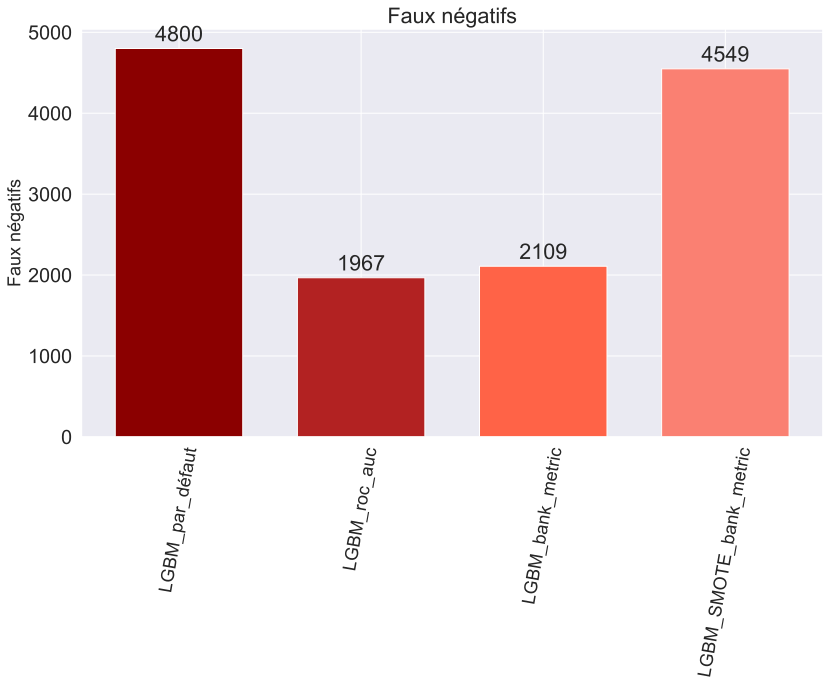

In [ ]:
labels = ['LGBM_par_défaut','LGBM_roc_auc', 'LGBM_bank_metric', 'LGBM_SMOTE_bank_metric']
FN = [4800, 1967, 2109, 4549]

x = np.arange(len(labels))  # the label locations
width = 0.7  # the width of the bars
fig, ax = plt.subplots(figsize = (12, 10))

rects = ax.bar(x, FN, width, color = ['darkred', 'firebrick', 'tomato', 'salmon'])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Faux négatifs', fontsize=18)
#ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels,fontsize=18, rotation=80)
#ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects)        
        
ax.set_title('Faux négatifs')

fig.tight_layout()

plt.show()

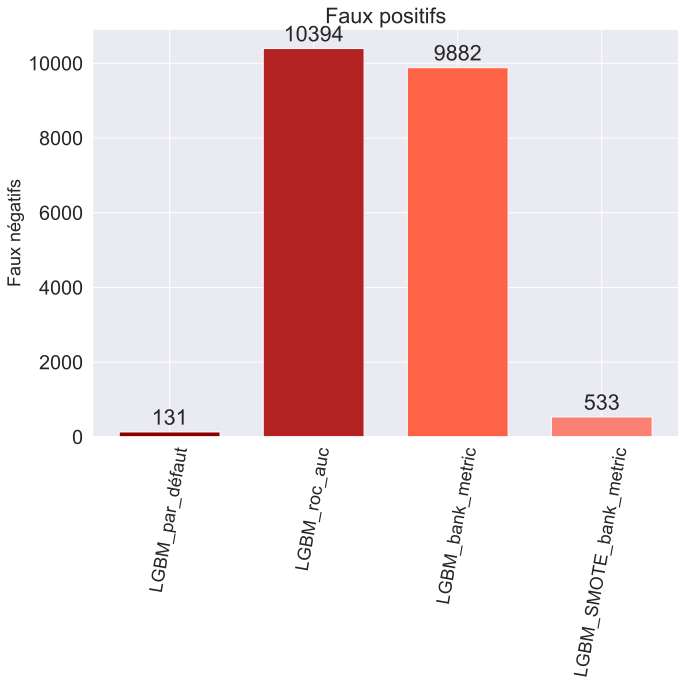

In [ ]:
labels = ['LGBM_par_défaut','LGBM_roc_auc', 'LGBM_bank_metric', 'LGBM_SMOTE_bank_metric']
FN = [131, 10394, 9882, 533]

x = np.arange(len(labels))  # the label locations
width = 0.7  # the width of the bars
fig, ax = plt.subplots(figsize = (10, 10))

rects = ax.bar(x, FN, width, color = ['darkred', 'firebrick', 'tomato', 'salmon'])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Faux négatifs', fontsize=18)
#ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels,fontsize=18, rotation=80)
#ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects)        
        
ax.set_title('Faux positifs')
fig.tight_layout()

plt.show()

### <span class="bg-warning"> 5.4 Scores des modèles LGBM dans différentes métriques et visualisation graphique<span> 
#### roc_auc, F1, précision, rappel, métrique "bancaire"

In [ ]:
####### Meilleurs modèles testés #############

#"""""""""""""""" Modèle de base """"""""""""""""""""""#
base_model_lgbm = LGBMClassifier(verbose=0)
# Train
base_model_lgbm.fit(X_train, y_train)


#"""""""""""""""" Modèle AUC """"""""""""""""""""""#
best_params = {
    'boosting_type' : 'gbdt',
    'num_leaves': 48,
    'max_depth': 11,
    'min_split_gain' : 0.1,
    'min_child_weight' : 80,
    'min_child_samples' : 18,
    'colsample_bytree' : 0.6685976111628331,
    'reg_alpha' : 0.3,
    'reg_lambda' : 0.1509731738366173,
    'subsample': 0.7257255326720535
}
# Modèle LGBM optimisé
lgbm_tuned_roc_auc = LGBMClassifier(**best_params,
                                    objective='binary',
                                    learning_rate=0.005,
                                    n_estimators=10000,
                                    class_weight='balanced',
                                    verbose=0)
# Train
lgbm_tuned_roc_auc.fit(X_train, y_train)


#"""""""""""""""" Modèle métrique bancaire """"""""""""""""""""""#
# Dictionnaire des meilleurs hyperparamètres
best_params = {
    'boosting_type' : 'gbdt',
    'num_leaves': 50,
    'max_depth': 11,
    'min_split_gain' : 0.0,
    'min_child_weight' : 5,
    'min_child_samples' : 5,
    'colsample_bytree' : 1.0,
    'reg_alpha' : 0.3,
    'reg_lambda' : 0.001,
    'subsample': 1.0
}
# Modèle LightGBM optimisé bank_metric
lgbm_tuned_bank_metric = LGBMClassifier(**best_params,
                                        objective='binary',
                                        learning_rate=0.005,
                                        n_estimators=10000,
                                        force_col_wise=True,
                                        class_weight ='balanced',
                                        verbose=0)
# Train
lgbm_tuned_bank_metric.fit(X_train, y_train)

#"""""""""""""""" Modèle SMOTE métrique bancaire """"""""""""""""""""""#
# Dictionnaire des meilleurs hyperparamètres
best_params = {
    'boosting_type' : 'gbdt',
    'num_leaves': 60,
    'max_depth': 0,
    'min_split_gain' : 0.010836837412299384,
    'min_child_weight' : 80,
    'min_child_samples' : 41,
    'colsample_bytree' : 1.0,
    'reg_alpha' : 0.001,
    'reg_lambda' :  0.001,
    'subsample': 0.9492735997671372
}
# Modèle LightGBM SMOTE optimisé bank_metric
lgbm_tuned_SMOTE_bank_metric = LGBMClassifier(**best_params,
                                        objective='binary',
                                        learning_rate=0.05,
                                        n_estimators=5000,      
                                        force_col_wise=True,      
                                        verbose=0)
# Train
lgbm_tuned_SMOTE_bank_metric.fit(X_train, y_train)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMClassifier(force_col_wise=True, learning_rate=0.05, max_depth=0,
               min_child_samples=41, min_child_weight=80,
               min_split_gain=0.010836837412299384, n_estimators=5000,
               num_leaves=60, objective='binary', reg_alpha=0.001,
               reg_lambda=0.001, subsample=0.9492735997671372, verbose=0)

In [ ]:
# Meilleur modèle
lgbm_tuned_roc_auc

LGBMClassifier(class_weight='balanced', colsample_bytree=0.6685976111628331,
               learning_rate=0.005, max_depth=11, min_child_samples=18,
               min_child_weight=80, min_split_gain=0.1, n_estimators=10000,
               num_leaves=48, objective='binary', reg_alpha=0.3,
               reg_lambda=0.1509731738366173, subsample=0.7257255326720535,
               verbose=0)

#### <span class="bg-success"> 5.4.1 Scores des 4 modèles LGBM sur le jeu de validation<span> 

In [ ]:
#################   Jeu de validation   ####################
# Scores des modèles LGBM dans différentes métriques 

# Prédiction base_model_lgbm
y_pred = base_model_lgbm.predict(X_valid)
y_proba = base_model_lgbm.predict_proba(X_valid)[:, 1]
dfa = calcul_scores(y_valid,
                    y_pred,
                    y_proba,
                    title='base_model_lgbm',
                    metrics=[
                        'roc_auc_score',
                        'bank_metric',
                        'f1_score',
                        'recall_score',
                        'precision_score',
                    ])

# Prédictions lgbm_tuned_roc_auc
y_pred = lgbm_tuned_roc_auc.predict(X_valid)
y_proba = lgbm_tuned_roc_auc.predict_proba(X_valid)[:, 1]
dfb = calcul_scores(y_valid,
                    y_pred,
                    y_proba,
                    title='lgbm_tuned_roc_auc',
                    metrics=[
                        'roc_auc_score',
                        'bank_metric',
                        'f1_score',
                        'recall_score',
                        'precision_score',
                    ])

# Prédictions lgbm_tuned_bank_metric
y_pred = lgbm_tuned_bank_metric.predict(X_valid)
y_proba = lgbm_tuned_bank_metric.predict_proba(X_valid)[:, 1]
dfc = calcul_scores(y_valid,
                    y_pred,
                    y_proba,
                    title='lgbm_tuned_bank_metric',
                    metrics=[
                        'roc_auc_score',
                        'bank_metric',
                        'f1_score',
                        'recall_score',
                        'precision_score',
                    ])

# Prédictions lgbm_tuned_SMOTE_bank_metric
y_pred = lgbm_tuned_SMOTE_bank_metric.predict(X_valid)
y_proba = lgbm_tuned_SMOTE_bank_metric.predict_proba(X_valid)[:, 1]
dfd = calcul_scores(y_valid,
                    y_pred,
                    y_proba,
                    title='lgbm_tuned_SMOTE_bank_metric',
                    metrics=[
                        'roc_auc_score',
                        'bank_metric',
                        'f1_score',
                        'recall_score',
                        'precision_score',
                    ])

df = pd.concat([dfa, dfb], axis=1)
df = pd.concat([df, dfc], axis=1)
df = pd.concat([df, dfd], axis=1)
df

,base_model_lgbm,lgbm_tuned_roc_auc,lgbm_tuned_bank_metric,lgbm_tuned_SMOTE_bank_metric
roc_auc_score,0.789138,0.791848,0.785072,0.765785
bank_metric,0.546738,0.716879,0.708329,0.564141
f1_score,0.062726,0.326633,0.322657,0.131629
recall_score,0.033233,0.603827,0.575227,0.076737
precision_score,0.557432,0.223865,0.224211,0.462379


,base_model_lgbm,lgbm_tuned_roc_auc,lgbm_tuned_bank_metric,lgbm_tuned_SMOTE_bank_metric
roc_auc_score,0.789138,0.790991,0.787637,0.770525
bank_metric,0.546738,0.549507,0.711323,0.561466
f1_score,0.062726,0.073851,0.324760,0.122007
recall_score,0.033233,0.039476,0.583686,0.070292
precision_score,0.557432,0.571429,0.224965,0.461640


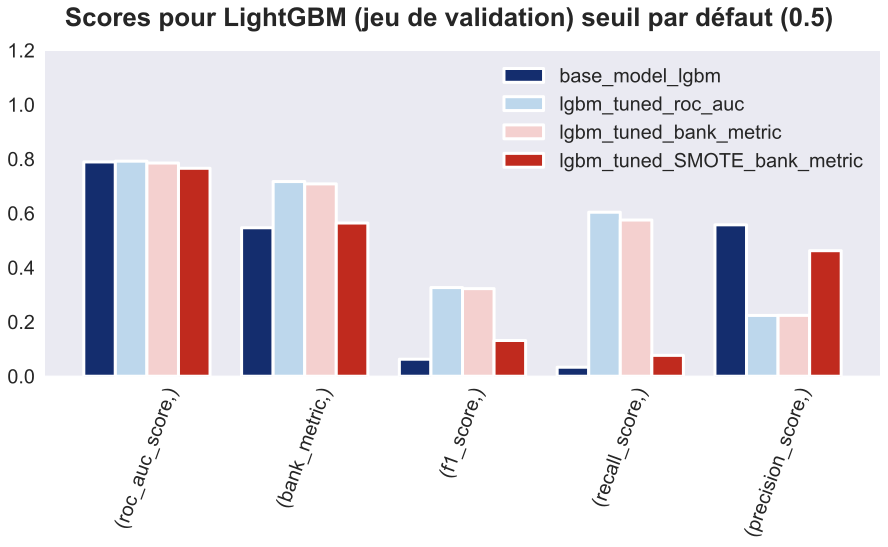

In [ ]:
# Visualisation : lgbm, seuillage par défaut, jeu de validation
color = ['#142D6E', '#BDD7EC', '#F4D0CF', '#C02A1E']
df.plot.bar(width=0.8, edgecolor='white', linewidth=3, color=color)
plt.gca().set(ylim=(0, 1.2))
plt.gcf().set_size_inches(15, 6)
plt.xticks(rotation=70)
plt.suptitle("Scores pour LightGBM (jeu de validation) seuil par défaut (0.5)",
             fontweight='bold')
plt.grid()
plt.show()

### <span class="bg-warning"> 5.5 Seuil de solvabilité : LightGBM - métrique bancaire<span> 

#### <span class="bg-success"> 5.5.1 Recherche du seuil de solvabilté optimum<span> 

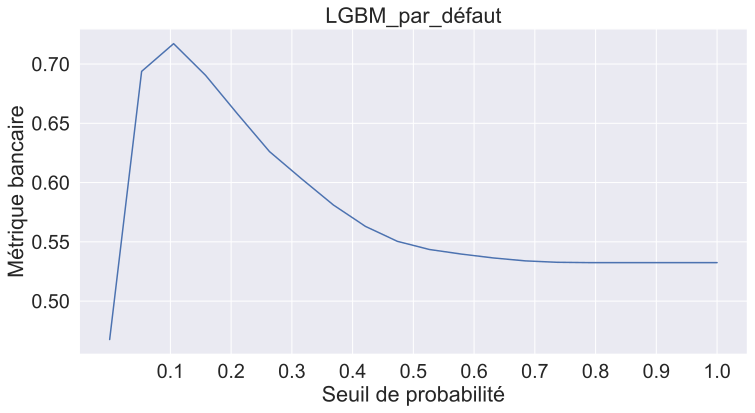

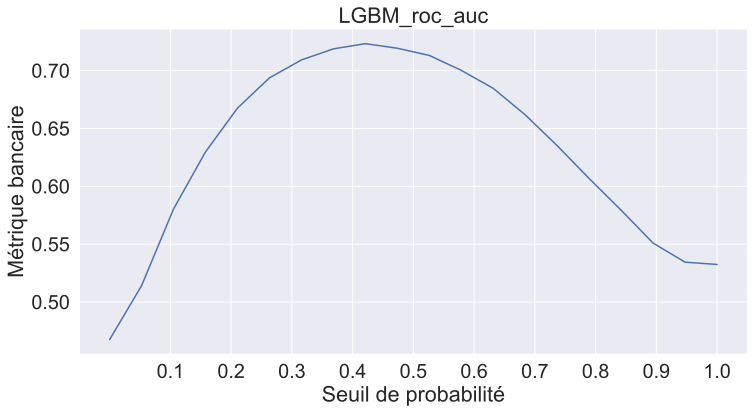

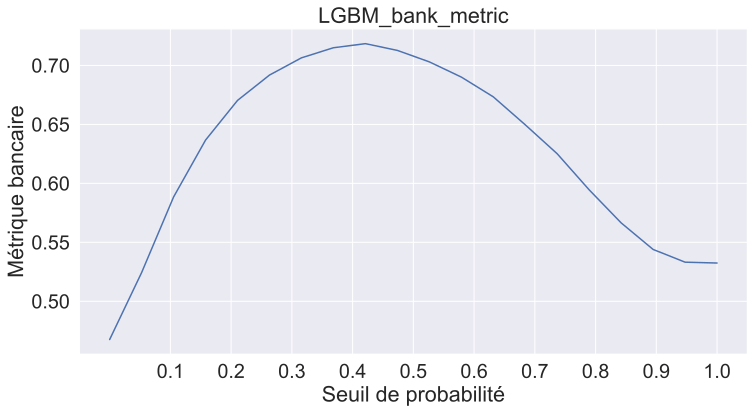

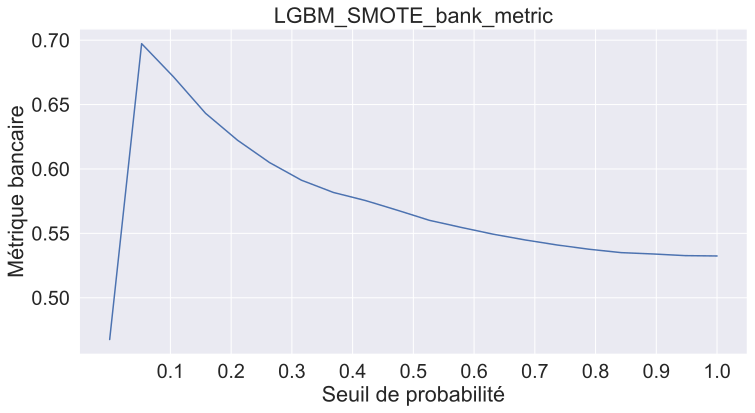

In [ ]:
dict_models ={'LGBM_par_défaut' : base_model_lgbm, 
         'LGBM_roc_auc' :lgbm_tuned_roc_auc,
         'LGBM_bank_metric' : lgbm_tuned_bank_metric, 
         'LGBM_SMOTE_bank_metric' : lgbm_tuned_SMOTE_bank_metric}

for key, value in dict_models.items():
        seuil_solvabilité(value, y_valid, X_valid, title=key, n=1)

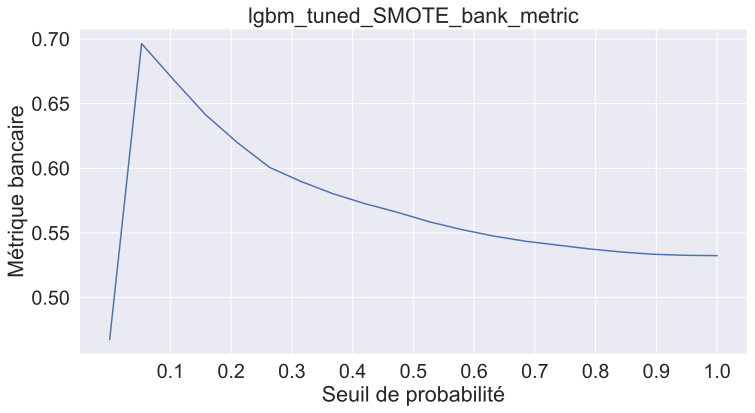

In [ ]:
seuil_solvabilité(lgbm_tuned_SMOTE_bank_metric, y_valid, X_valid, title='lgbm_tuned_SMOTE_bank_metric', n=1)

#### <span class="bg-success"> 5.5.2 Fixation du seuil de solvabilté - Jeu d'entrainement<span> 

##### Scores roc_auc, rappel, précision, F1, métrique bancaire 

In [ ]:
#################        Jeu d'entrainement         ##################
# Score du modèle dans différentes métriques après seuillage différencié

# base_model_LGBM
y_pred = base_model_lgbm.predict(X_train)
y_pred_seuil = (base_model_lgbm.predict_proba(X_train)[:, 1] >=
                0.11).astype('bool')

df0 = calcul_scores(y_train,
                    y_pred,
                    y_pred_seuil,
                    title='base_model_lgbm',
                    metrics=[
                        'roc_auc_score',
                        'bank_metric',
                        'f1_score',
                        'recall_score',
                        'precision_score',
                    ])


# LGBM optimisé roc_auc
y_pred = lgbm_tuned_roc_auc.predict(X_train)
y_pred_seuil = (lgbm_tuned_roc_auc.predict_proba(X_train)[:, 1] >=
                0.41).astype('bool')

df1 = calcul_scores(y_train,
                    y_pred,
                    y_pred_seuil,
                    title='lgbm_tuned_roc_auc',
                    metrics=[
                        'roc_auc_score',
                        'bank_metric',
                        'f1_score',
                        'recall_score',
                        'precision_score',
                    ])


# LGBM optimisé bank_metric
y_pred = lgbm_tuned_bank_metric.predict(X_train)
y_pred_seuil = (lgbm_tuned_bank_metric.predict_proba(X_train)[:, 1] >=
                0.41).astype('bool')

df2 = calcul_scores(y_train,
                    y_pred,
                    y_pred_seuil,
                    title='lgbm_tuned_bank_metric',
                    metrics=[
                        'roc_auc_score',
                        'bank_metric',
                        'f1_score',
                        'recall_score',
                        'precision_score',
                    ])



In [ ]:
# LGBM optimisé SMOTE bank_metric
y_pred = lgbm_tuned_SMOTE_bank_metric.predict(X_train)
y_pred_seuil = (lgbm_tuned_SMOTE_bank_metric.predict_proba(X_train)[:, 1] >=
                0.08).astype('bool')

df3 = calcul_scores(y_train,
                    y_pred,
                    y_pred_seuil,
                    title='lgbm_tuned_SMOTE_bank_metric',
                    metrics=[
                        'roc_auc_score',
                        'bank_metric',
                        'f1_score',
                        'recall_score',
                        'precision_score',
                    ])

df_train = pd.concat([df0, df1], axis=1)
df_train = pd.concat([df_train, df2], axis=1)
df_train = pd.concat([df_train, df3], axis=1)

In [ ]:
df_train

,base_model_lgbm,lgbm_tuned_roc_auc,lgbm_tuned_bank_metric,lgbm_tuned_SMOTE_bank_metric
roc_auc_score,0.746341,0.869202,0.877154,0.976617
bank_metric,0.555334,0.883423,0.891717,0.991899
f1_score,0.094874,0.495356,0.517005,0.991239
recall_score,0.050604,0.934542,0.937261,0.982679
precision_score,0.757919,0.336989,0.356952,0.999949


##### Visualisation seuillage - effet sur les différentes métriques

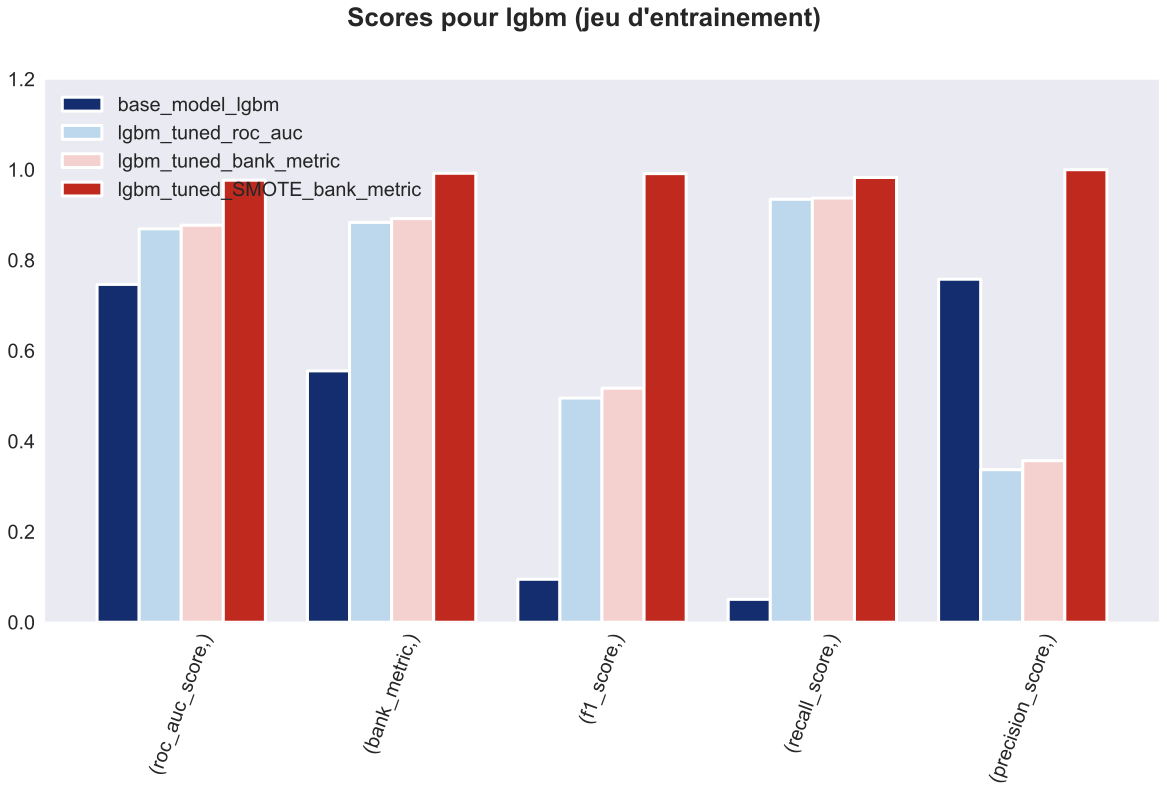

In [ ]:
# Visualisation : lgbm, seuillage, jeu d'entrainement 
color = ['#142D6E', '#BDD7EC', '#F4D0CF', '#C02A1E']
df_train.plot.bar(width=0.8, edgecolor='white', linewidth=3, color=color)
plt.gca().set(ylim=(0,1.2))
plt.gcf().set_size_inches(20,10)
plt.xticks(rotation=70)
plt.suptitle("Scores pour lgbm (jeu d'entrainement)",
            fontweight='bold')
plt.grid()
plt.show()

##### Matrices de confusion 

In [ ]:
# Modèles seuil à 0.11
dict_models_1 = {
    'LGBM_par_défaut': base_model_lgbm,
    
    #'LGBM_SMOTE_bank_metric': lgbm_tuned_SMOTE_bank_metric
}
# Modèle seuil à 0.41
dict_models_2 = {
    'LGBM_bank_metric': lgbm_tuned_bank_metric,
    'LGBM_roc_auc': lgbm_tuned_roc_auc,
}
# Modèles seuil à 0.08
dict_models_3 = {
    'lgbm_tuned_SMOTE_bank_metric':lgbm_tuned_SMOTE_bank_metric}

<Figure size 864x576 with 0 Axes>

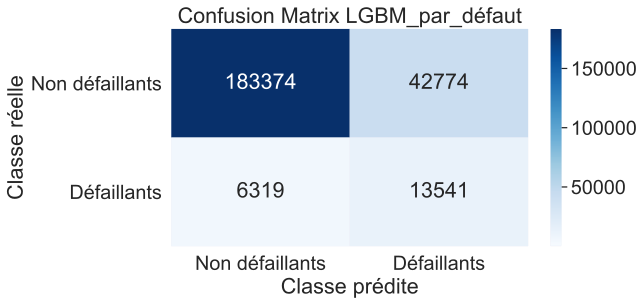

In [ ]:
for key, value in dict_models_1.items():
    #Prediction on train data, seuil 0.11
    y_proba = value.predict_proba(X_train)[:, 1]
    y_pred = (y_proba > 0.11)
    y_pred = np.array(y_pred > 0) * 1
    # Matrice de confusion
    plot_matrice_confusion(y_train, y_pred, title=key)
    plt.show()

<Figure size 864x576 with 0 Axes>

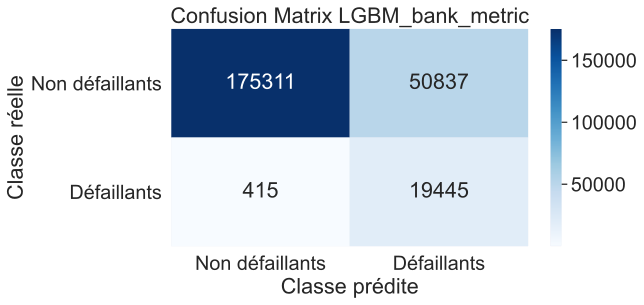

<Figure size 864x576 with 0 Axes>

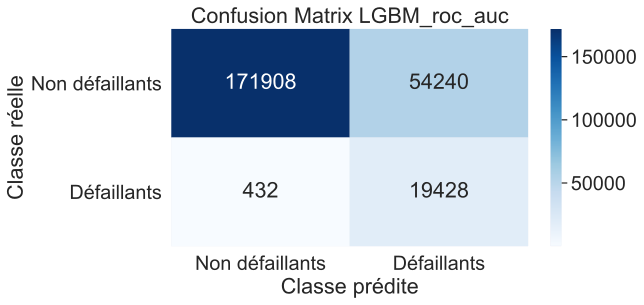

In [ ]:
for key, value in dict_models_2.items():
    #Prediction on train data, seuil 0.41
    y_proba = value.predict_proba(X_train)[:, 1]
    y_pred = (y_proba > 0.41)
    y_pred = np.array(y_pred > 0) * 1
    # Matrice de confusion
    plot_matrice_confusion(y_train, y_pred, title=key)
    plt.show()

<Figure size 864x576 with 0 Axes>

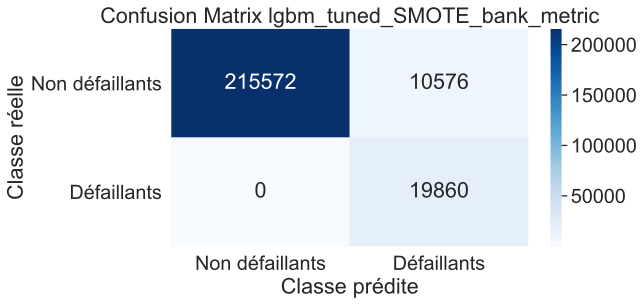

In [ ]:
#Prediction on train data, seuil 0.08
y_proba = lgbm_tuned_SMOTE_bank_metric.predict_proba(X_train)[:, 1]
y_pred = (y_proba > 0.08)
y_pred = np.array(y_pred > 0) * 1
# Matrice de confusion
plot_matrice_confusion(y_train, y_pred, title='lgbm_tuned_SMOTE_bank_metric')
plt.show()

#### <span class="bg-success"> 5.5.3 Fixation du seuil de solvabilté - Jeu de validation<span> 

##### Scores roc_auc, rappel, précision, F1, métrique bancaire 

In [ ]:
#################   Jeu de validation   ##################
# Score du modèle dans différentes métriques après seuillage 0.08


# base_model_LGBM
y_pred = base_model_lgbm.predict(X_valid)
y_pred_seuil = (base_model_lgbm.predict_proba(X_valid)[:, 1] >=
                0.11).astype('bool')

df4 = calcul_scores(y_valid,
                    y_pred,
                    y_pred_seuil,
                    title='base_model_lgbm',
                    metrics=[
                        'roc_auc_score',
                        'bank_metric',
                        'f1_score',
                        'recall_score',
                        'precision_score',
                    ])


# LGBM optimisé roc_auc
y_pred = lgbm_tuned_roc_auc.predict(X_valid)
y_pred_seuil = (lgbm_tuned_roc_auc.predict_proba(X_valid)[:, 1] >=
                0.41).astype('bool')

df5 = calcul_scores(y_valid,
                    y_pred,
                    y_pred_seuil,
                    title='lgbm_tuned_roc_auc',
                    metrics=[
                        'roc_auc_score',
                        'bank_metric',
                        'f1_score',
                        'recall_score',
                        'precision_score',
                    ])


# LGBM optimisé bank_metric
y_pred = lgbm_tuned_bank_metric.predict(X_valid)
y_pred_seuil = (lgbm_tuned_bank_metric.predict_proba(X_valid)[:, 1] >=
                0.41).astype('bool')

df6 = calcul_scores(y_valid,
                    y_pred,
                    y_pred_seuil,
                    title='lgbm_tuned_bank_metric',
                    metrics=[
                        'roc_auc_score',
                        'bank_metric',
                        'f1_score',
                        'recall_score',
                        'precision_score',
                    ])




In [ ]:
# LGBM SMOTE optimisé bank_metric
y_pred = lgbm_tuned_SMOTE_bank_metric.predict(X_valid)
y_pred_seuil = (lgbm_tuned_SMOTE_bank_metric.predict_proba(X_valid)[:, 1] >=
                0.08).astype('bool')

df7 = calcul_scores(y_valid,
                    y_pred,
                    y_pred_seuil,
                    title='lgbm_tuned_SMOTE_bank_metric',
                    metrics=[
                        'roc_auc_score',
                        'bank_metric',
                        'f1_score',
                        'recall_score',
                        'precision_score',
                    ])

df_valid = pd.concat([df4, df5], axis=1)
df_valid = pd.concat([df_valid, df6], axis=1)
df_valid = pd.concat([df_valid, df7], axis=1)

In [ ]:
df_valid

,base_model_lgbm,lgbm_tuned_roc_auc,lgbm_tuned_bank_metric,lgbm_tuned_SMOTE_bank_metric
roc_auc_score,0.708872,0.721685,0.716792,0.674035
bank_metric,0.546738,0.716879,0.708329,0.564141
f1_score,0.062726,0.326633,0.322657,0.131629
recall_score,0.033233,0.603827,0.575227,0.076737
precision_score,0.557432,0.223865,0.224211,0.462379


##### Visualisation seuillage - effet sur les différentes métriques

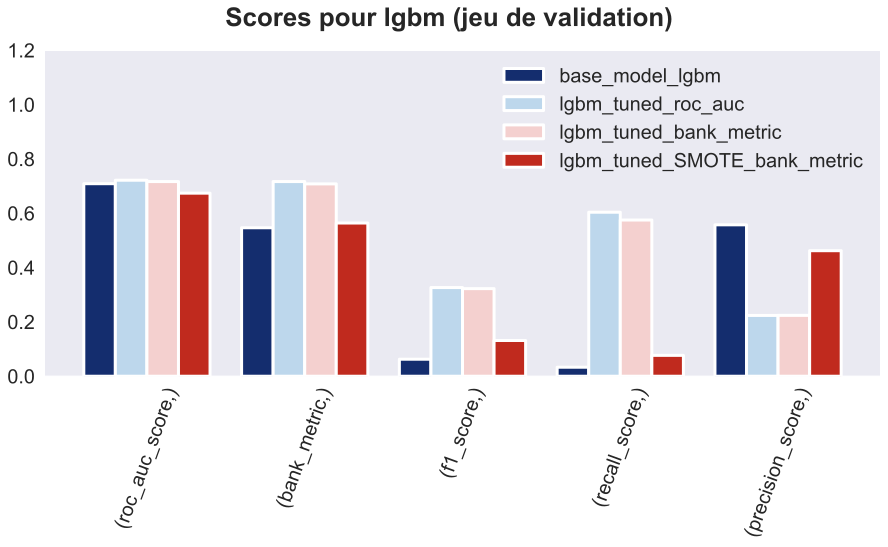

In [ ]:
# Visualisation : lgbm, seuillage, jeu d'entrainement 

color = ['#142D6E', '#BDD7EC', '#F4D0CF', '#C02A1E']
df_valid.plot.bar(width=0.8, edgecolor='white', linewidth=3, color=color)
plt.gca().set(ylim=(0,1.2))
plt.gcf().set_size_inches(15,6)
plt.xticks(rotation=70)
plt.suptitle("Scores pour lgbm (jeu de validation)",
            fontweight='bold')
plt.grid()
plt.show()

##### Matrices de confusion

<Figure size 864x576 with 0 Axes>

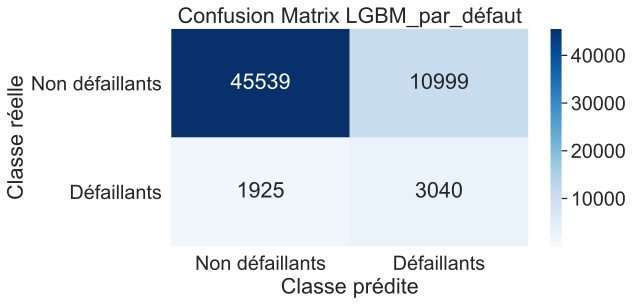

In [ ]:
#Modèles seuil à 0.11
for key, value in dict_models_1.items():
    #Prediction on train data, seuil 0.11
    y_proba = value.predict_proba(X_valid)[:, 1]
    y_pred = (y_proba > 0.11)
    y_pred = np.array(y_pred > 0) * 1
    # Matrice de confusion
    plot_matrice_confusion(y_valid, y_pred, title=key)
    plt.show()

<Figure size 864x576 with 0 Axes>

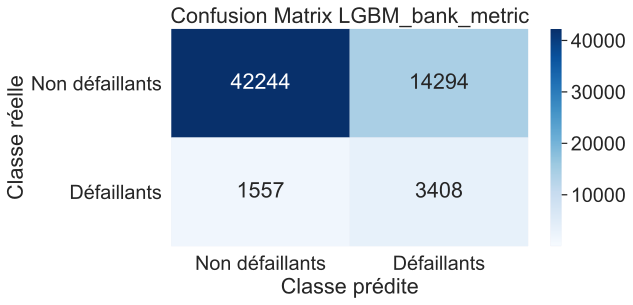

<Figure size 864x576 with 0 Axes>

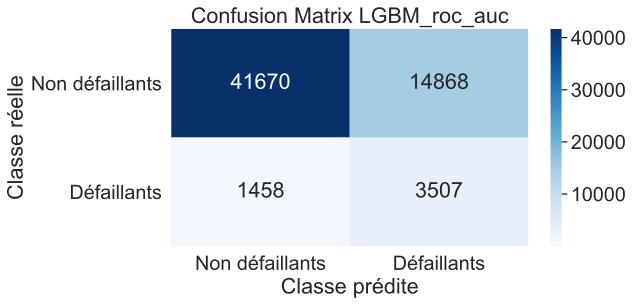

In [ ]:
# Modèles seuil à 0.41
for key, value in dict_models_2.items():
    #Prediction on validation data, seuil 0411529
    y_proba = value.predict_proba(X_valid)[:, 1]
    y_pred = (y_proba > 0.41)
    y_pred = np.array(y_pred > 0) * 1
    # Matrice de confusion
    plot_matrice_confusion(y_valid, y_pred, title=key)
    plt.show()

<Figure size 864x576 with 0 Axes>

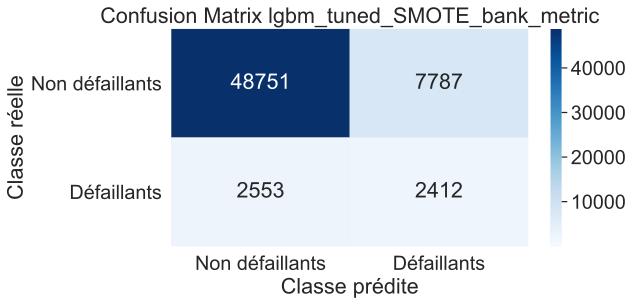

In [ ]:
#Prediction on validation data, seuil 0.08
y_proba = lgbm_tuned_SMOTE_bank_metric.predict_proba(X_valid)[:, 1]
y_pred = (y_proba > 0.08)
y_pred = np.array(y_pred > 0) * 1
# Matrice de confusion
plot_matrice_confusion(y_valid, y_pred, title='lgbm_tuned_SMOTE_bank_metric')
plt.show()

 ### <span class="bg-warning"> 5.6 Evolution des Faux Négatifs après seuillage pour les 4 modèles LGBM<span> 

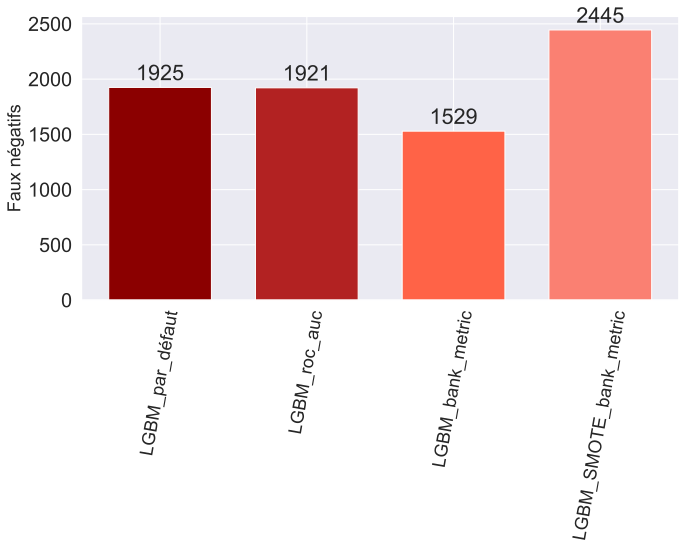

In [ ]:
labels = ['LGBM_par_défaut','LGBM_roc_auc', 'LGBM_bank_metric', 'LGBM_SMOTE_bank_metric']
FN = [1925, 1921, 1529, 2445]

x = np.arange(len(labels))  # the label locations
width = 0.7  # the width of the bars
fig, ax = plt.subplots(figsize = (10, 8))

rects = ax.bar(x, FN, width, color = ['darkred', 'firebrick', 'tomato', 'salmon'])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Faux négatifs', fontsize=18)
#ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels,fontsize=18, rotation=80)
#ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects)        
        

fig.tight_layout()

plt.show()

### <span class="bg-warning"> 5.7 Exportation du meilleur modèle : LightGBM  AUC<span> 

In [ ]:
#Utilisation de JobLib pour sérialiser et enregistrer le meilleur modèle 
from joblib import dump, load
# save model catboost tuned  to disk
dump(lgbm_tuned_roc_auc, 'best_lgbm.joblib', compress=2)

['best_lgbm.joblib']

## <span class="bg-info"> 6 Interprétabilité du meilleur modèle : LightGBM<span> 

In [ ]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (14, 10))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:20]))), 
            df['importance_normalized'].head(20), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:20]))))
    ax.set_yticklabels(df['feature'].head(20))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [ ]:
best_model = lgbm_tuned_roc_auc

In [ ]:
feature_importance_values = best_model.feature_importances_

In [ ]:
feature_names = list(X_train.columns)

In [ ]:
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

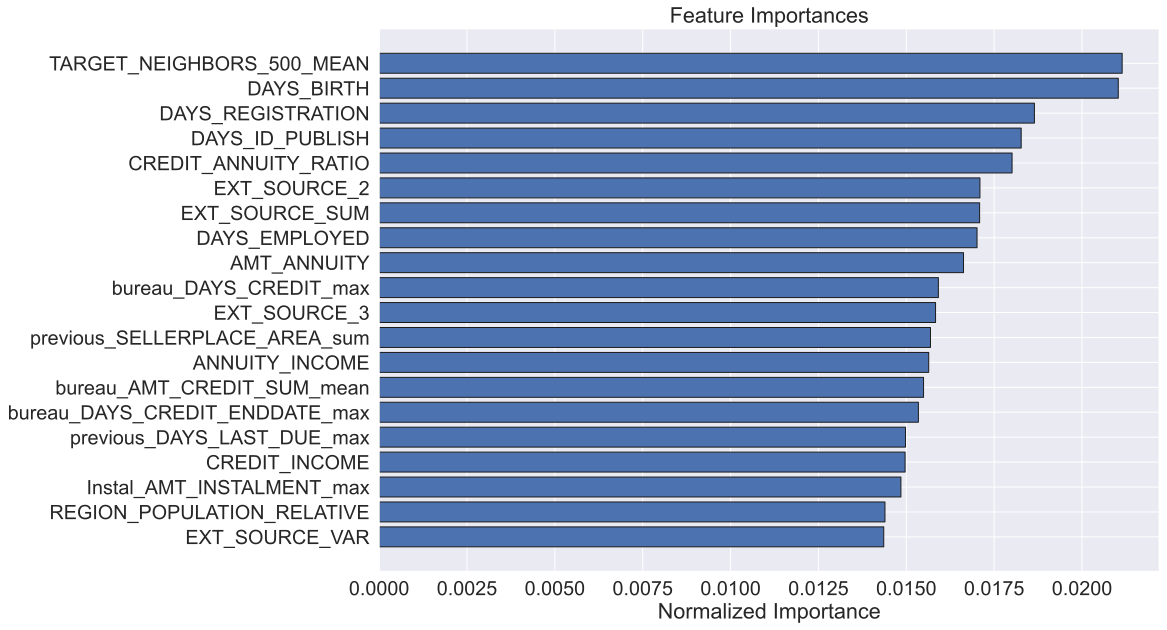

In [ ]:
# Show the feature importances for the new features
feature_importances_sorted = plot_feature_importances(feature_importances)